# 迁移学习——手写数字加法机

我们实现了一个手写数字加法机，它可以通过识别输入的两个手写体图像文件，从而计算两个数字的和，并给出输出。我们展示了三种不同的迁移学习方式，并对它们进行了系统化的比较：

1、没有迁移学习，网络完全从头学习如何识别数字，如何计算加法；

2、将已训练好的手写数字识别器网络迁移过来，作为预训练权重；

3、将已训练好的手写数字识别器网络迁移过来，并作为不可修改的权重。


In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

%matplotlib inline

## 一、加载数据

首先一个问题是如何加载成对的图像数据？我们采用的解决方案是采用了两套采样器和加载器，
这样每一组采样器＋加载器都独立地从原始的数据集中抽样数据，这就让我们可以获得大量不重复
的手写数字图像对，从而可以训练我们的神经网络。

In [2]:

# 设置图像读取器的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64  #批处理的尺寸大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

# 加载测试数据集
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


# 定义两个采样器，每一个采样器都随机地从原始的数据集中抽样数据。抽样数据采用permutation
# 生成任意一个下标重排，从而利用下标来提取dataset中的数据
sample_size = len(train_dataset)
sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.choice(range(len(train_dataset)), sample_size))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.choice(range(len(train_dataset)), sample_size))

# 定义两个加载器，分别封装了前两个采样器，实现采样。
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           sampler = sampler2
                                           )

# 对于校验数据和测试数据，我们进行类似的处理。
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# 为了比较不同数据量对迁移学习的影响，我们设定了一个加载数据的比例fraction
# 即我们只加载原训练数据集的1/fraction来训练网络
fraction = 30

## 二、加载网络

为了实现迁移学习，我们需要从硬盘上加载已经训练好的手写数字识别器卷积神经网络，加载网络需要经过两个步骤：

1、定义网络模块（nn.Module）的框架，即新定义类ConvNet，实现其forwar函数；

2、从硬盘文件加载网络

3、通过绘制其卷积核，验证加载到的网络和导出的网络一致

### 1. 定义网络架构

In [3]:
# 定义待迁移的网络框架，所有的神经网络模块包括：Conv2d、MaxPool2d，Linear等模块都不需要重新定义，会自动加载
# 但是网络的forward功能没有办法自动实现，需要重写。
# 一般的，加载网络只加载网络的属性，不加载方法
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim=1) #log_softmax可以理解为概率对数值
        return x

### 2. 从硬盘文件加载网络

网络加载命令如下：

In [4]:
original_net = torch.load('minst_conv_checkpoint') #读取硬盘上的minst_conv_checkpoint文件

In [5]:
original_net #将网络打印出来观看（只能看到其神经模块和架构）

ConvNet(
  (conv1): Conv2d (1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=392, out_features=512)
  (fc2): Linear(in_features=512, out_features=10)
)

### 3. 检测加载的正确性

通过测试它在测试数据集上的分类准确度，以及绘制其卷积核，并与导出的程序（minist_convnet.ipynb）中的分类准确度、卷积核等是否相同判断

In [6]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

#在测试集上分批运行，并计算总的正确率
original_net.eval() #标志模型当前为运行阶段
test_loss = 0
correct = 0
vals = []

#对测试数据集进行循环
for data, target in test_loader1:
    data, target = Variable(data, volatile=True), Variable(target)
    output = original_net(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate


0.991

标签是： 4


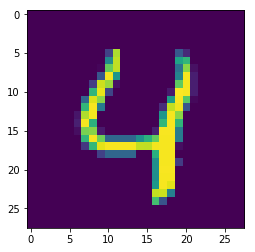

In [7]:
#随便从测试集中读入一张图片，并绘制出来
idx = 4
muteimg = test_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...])
print('标签是：',test_dataset[idx][1])


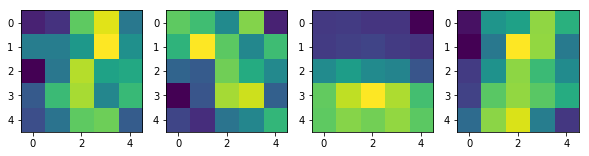

In [8]:
#提取第一层卷积层的卷积核
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.imshow(original_net.conv1.weight.data.numpy()[i,0,...])


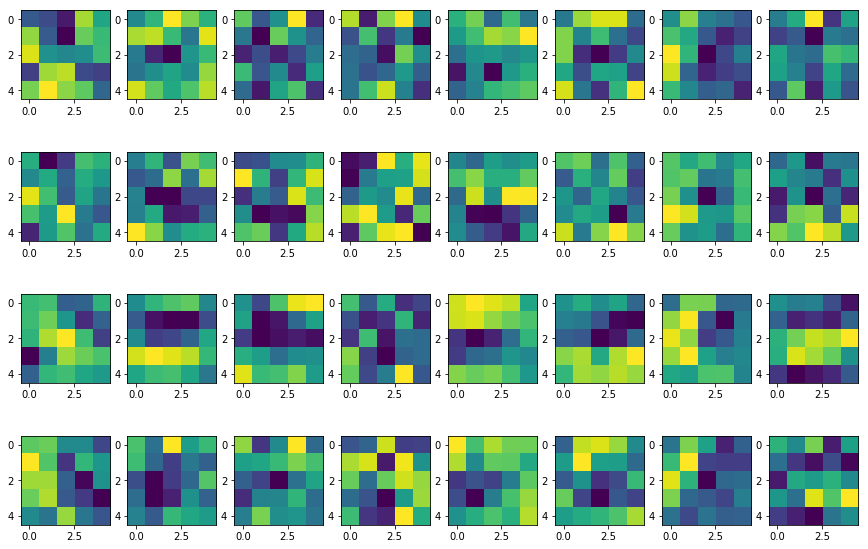

In [9]:
# 绘制第二层的卷积核
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.imshow(original_net.conv2.weight.data.numpy()[j, i,...])

## 三、数字加法机的实现

数字加法机：输入两张图像，输出这两个手写数字的加法。网络的架构如下：

两个并行的卷积模块：两个卷积层、两个Pooling层；一个全链接模块：最多四层全链接层。

In [10]:
depth = [4, 8]
class Transfer(nn.Module):
    def __init__(self):
        super(Transfer, self).__init__()
        # 两个并行的卷积通道，第一个通道：
        self.net1_conv1 = nn.Conv2d(1, 4, 5, padding = 2) #一个输入通道，4个输出通道（4个卷积核），窗口为5，填充2
        self.net_pool = nn.MaxPool2d(2, 2) #2*2 池化
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #输入通道4，输出通道8（8个卷积核），窗口5，填充2
        
        # 第二个通道，注意pooling操作不需要重复定义
        self.net2_conv1 = nn.Conv2d(1, 4, 5, padding = 2) #一个输入通道，4个输出通道（4个卷积核），窗口为5，填充2
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #输入通道4，输出通道8（8个卷积核），窗口5，填充2
        
        # 全链接层
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 1024) #输入为处理后的特征图压平，输出1024个单元
        self.fc2 = nn.Linear(1024, 2 * num_classes) #输入1024个单元，输出20个单元
        self.fc3 = nn.Linear(2 * num_classes, num_classes) #输入20个单元，输出10个单元
        self.fc4 = nn.Linear(num_classes, 1) #输入10个单元，输出为1

    def forward(self, x, y, training = True):
        # 网络的前馈过程。输入两张手写图像x和y，输出一个数字表示两个数字的和
        # x,y都是batch_size*image_size*image_size形状的三阶张量
        # 输出为batch_size长的列向量
        
        # 首先，第一张图像进入第一个通道
        x = F.relu(self.net1_conv1(x)) #第一层卷积
        x = self.net_pool(x)   # 第一层池化
        x = F.relu(self.net1_conv2(x))  # 第二层卷积
        x = self.net_pool(x) # 第二层池化
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1]) # 将特征图张量压平
        
        
        y = F.relu(self.net2_conv1(y)) #第一层卷积
        y = self.net_pool(y) # 第一层池化
        y = F.relu(self.net2_conv2(y)) #第二层卷积
        y = self.net_pool(y) #第二层池化
        y = y.view(-1, image_size // 4 * image_size // 4 * depth[1])# 将特征图张量压平
        
        # 将两个卷积过来的铺平向量拼接在一起，形成一个大向量
        z = torch.cat((x, y), 1) #cat函数为拼接向量操作，1表示拼接的维度为第1个维度（0维度对应了batch）
        z = self.fc1(z) #第一层全链接
        z = F.relu(z)  #对于深层网络来说，激活函数用relu效果会比较好
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z) #第二层全链接
        z = F.relu(z)
        z = self.fc3(z) #第三层全链接
        z = F.relu(z)
        z = self.fc4(z) # 第四层全链接
        return z
    def set_filter_values(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为预训练式
        # 输入参数net为从硬盘加载的网络作为迁移源
        
        # 逐个儿为网络的两个卷积模块的权重和偏置进行赋值
        # 注意在赋值的时候需要用deepcopy而不能直接等于，或者copy。
        # 这是因为这种拷贝是将张量中的数值全部拷贝到了目标中，而不是拷贝地址
        # 如果不用deepcopy，由于我们将同一组参数（net.conv1.weight.data,bias）
        #  赋予了两组参数（net1_conv1.weight.data，net2_conv1.weight.data）
        # 所以它们会共享源net.conv1.weight.data中的地址，这样对于net1_conv1.weight.data
        # 的训练也自然会被用到了net2_conv1.weight.data中，但其实我们希望它们是两个不同的参数。
        self.net1_conv1.weight.data = copy.deepcopy(net.conv1.weight.data)
        self.net1_conv1.bias.data = copy.deepcopy(net.conv1.bias.data)
        self.net1_conv2.weight.data = copy.deepcopy(net.conv2.weight.data)
        self.net1_conv2.bias.data = copy.deepcopy(net.conv2.bias.data)
        self.net2_conv1.weight.data = copy.deepcopy(net.conv1.weight.data)
        self.net2_conv1.bias.data = copy.deepcopy(net.conv1.bias.data)
        self.net2_conv2.weight.data = copy.deepcopy(net.conv2.weight.data)
        self.net2_conv2.bias.data = copy.deepcopy(net.conv2.bias.data)
        
        # 将变量加载到GPU上        
        self.net1_conv1 = self.net1_conv1.cuda() if use_cuda else self.net1_conv1
        self.net1_conv2 = self.net1_conv2.cuda() if use_cuda else self.net1_conv2
        
        self.net2_conv1 = self.net2_conv1.cuda() if use_cuda else self.net2_conv1
        self.net2_conv2 = self.net2_conv2.cuda() if use_cuda else self.net2_conv2
    def set_filter_values_nograd(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为固定权重式
        # 调用set_filter_values为全部卷积核进行赋值
        self.set_filter_values(net)
        
        # 为了让我们的网络不被训练调整权值，我们需要设定每一个变量的requires_grad为False
        # 即不需要计算梯度值
        self.net1_conv1.weight.requires_grad = False
        self.net1_conv1.bias.requires_grad = False
        self.net1_conv2.weight.requires_grad = False
        self.net1_conv2.bias.requires_grad = False
        
        
        self.net2_conv1.weight.requires_grad = False
        self.net2_conv1.bias.requires_grad = False
        self.net2_conv2.weight.requires_grad = False
        self.net2_conv2.bias.requires_grad = False
def rightness(y, target):
    # 计算分类准确度的函数，y为模型预测的标签，target为数据的标签
    # 输入的y为一个矩阵，行对应了batch中的不同数据记录，列对应了不同的分类选择，数值对应了概率
    # 函数输出分别为预测与数据标签相等的个数，本次判断的所有数据个数
    out = torch.round(y.squeeze()).type(itype)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return(out, out1)

## 四、数据迁移实验

### 1. 无迁移实验

在本试验中，我们不迁移网络，直接训练整个网络

In [11]:
# 生成网络实例
net = Transfer()

# 如果存在GPU，则将网络加载到GPU中
if use_cuda:
    net = net.cuda()
    
# 定义损失函数，我们用最小均方误差来定义损失
criterion = nn.MSELoss()

# 定义优化器
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)
results = {}

In [12]:

# 开始训练网络
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    
    # 我们可以用zip命令来同时从两个数据加载器中加载数据，enumerate则给这个迭代附加上了计数
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        # 为了比较数据量大小对迁移学习的影响，我们只加载了部分数据，当数据加载个数idx大于
        # 全数据集的1/fraction的时候则不再加载后面的数据
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        optimizer.zero_grad()
        net.train()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
        loss = criterion(outputs, Variable(labels.type(dtype)))
        loss.backward()
        optimizer.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.data.numpy())
        if idx % 100 == 0:
            # 在校验数据上计算计算准确率
            val_losses = []
            rights = []
            net.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(Variable(x1), Variable(x2))
                labels = y1 + y2
                
                loss = criterion(outputs, Variable(labels.type(dtype)))
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.data.numpy())
                
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}周期，第({}/{})个撮，训练误差：{}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

# 在测试数据集上测试准确度
rights = []
net.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    outputs = net(Variable(x1), Variable(x2))
    labels = y1 + y2
    loss = criterion(outputs, Variable(labels.type(dtype)))
    right = rightness(outputs.data, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['notransfer'] = [records, right_ratio]  

第0周期，第(0/938)个撮，训练误差：103.1798324584961, 校验误差：96.37, 准确率：0.01
第1周期，第(0/938)个撮，训练误差：73.74192810058594, 校验误差：61.79, 准确率：0.03
第2周期，第(0/938)个撮，训练误差：20.267230987548828, 校验误差：16.87, 准确率：0.10
第3周期，第(0/938)个撮，训练误差：13.607555389404297, 校验误差：15.84, 准确率：0.10
第4周期，第(0/938)个撮，训练误差：14.450922012329102, 校验误差：15.20, 准确率：0.10
第5周期，第(0/938)个撮，训练误差：18.488815307617188, 校验误差：14.90, 准确率：0.10
第6周期，第(0/938)个撮，训练误差：10.28338623046875, 校验误差：14.09, 准确率：0.11
第7周期，第(0/938)个撮，训练误差：16.222244262695312, 校验误差：13.03, 准确率：0.11
第8周期，第(0/938)个撮，训练误差：11.76478385925293, 校验误差：12.41, 准确率：0.12
第9周期，第(0/938)个撮，训练误差：12.295241355895996, 校验误差：11.17, 准确率：0.12
第10周期，第(0/938)个撮，训练误差：11.771688461303711, 校验误差：10.42, 准确率：0.12
第11周期，第(0/938)个撮，训练误差：10.407386779785156, 校验误差：9.68, 准确率：0.12
第12周期，第(0/938)个撮，训练误差：8.351632118225098, 校验误差：9.06, 准确率：0.12
第13周期，第(0/938)个撮，训练误差：7.957727909088135, 校验误差：8.98, 准确率：0.12
第14周期，第(0/938)个撮，训练误差：10.15479850769043, 校验误差：8.66, 准确率：0.13
第15周期，第(0/938)个撮，训练误差：7.264214992523193, 校验误差：8.39, 准确率：0.13
第16周期，第(0/938)个

0.1668

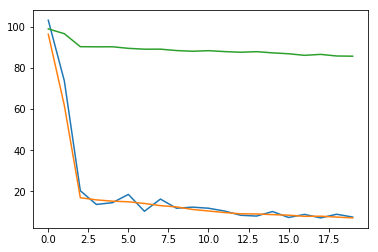

In [13]:
# 绘制实验结果，打印测试集上的准确度
plt.plot([i[0] for i in records])
plt.plot([i[1] for i in records])
plt.plot([100 * (1 - i[2]) for i in records])
right_ratio

### 2. 迁移网络，预训练

在本试验中，我们将手写数字识别的卷积神经网络权重迁移过来，作为新的加法机网络的预训练值（也就是初始值）

In [14]:
net = Transfer()

# 为新网络赋予权重数值，注意我们只将卷积部分的网络进行迁移，而没有迁移全链接层
net.set_filter_values(original_net)

if use_cuda:
    net = net.cuda()

criterion = nn.MSELoss()

# 将需要训练的参数加载到优化器中
new_parameters = []
for para in net.parameters():
    if para.requires_grad: #我们只将可以调整权重的变量加到了集合new_parameters
        new_parameters.append(para)
        
# 将new_parameters加载到了优化器中
optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)


In [15]:
# 开始训练网络
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net.train()
        optimizer.zero_grad()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
        loss = criterion(outputs, Variable(labels.type(dtype)))
        loss.backward()
        optimizer.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.data.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(Variable(x1), Variable(x2))
                labels = y1 + y2
                loss = criterion(outputs, Variable(labels.type(dtype)))
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.data.numpy())
                
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
rights = []
net.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    outputs = net(Variable(x1), Variable(x2))
    labels = y1 + y2
    loss = criterion(outputs, Variable(labels.type(dtype)))
    right = rightness(outputs.data, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer_pretrained'] = [records, right_ratio] 

第0周期，第(0/938)个撮，训练误差：83.52, 校验误差：92.14, 准确率：0.01
第1周期，第(0/938)个撮，训练误差：16.84, 校验误差：16.08, 准确率：0.09
第2周期，第(0/938)个撮，训练误差：14.09, 校验误差：9.61, 准确率：0.13
第3周期，第(0/938)个撮，训练误差：9.40, 校验误差：9.19, 准确率：0.13
第4周期，第(0/938)个撮，训练误差：10.89, 校验误差：8.40, 准确率：0.13
第5周期，第(0/938)个撮，训练误差：5.92, 校验误差：8.04, 准确率：0.14
第6周期，第(0/938)个撮，训练误差：7.01, 校验误差：7.65, 准确率：0.13
第7周期，第(0/938)个撮，训练误差：5.70, 校验误差：7.50, 准确率：0.13
第8周期，第(0/938)个撮，训练误差：5.36, 校验误差：7.52, 准确率：0.14
第9周期，第(0/938)个撮，训练误差：7.69, 校验误差：6.94, 准确率：0.14
第10周期，第(0/938)个撮，训练误差：6.09, 校验误差：6.67, 准确率：0.15
第11周期，第(0/938)个撮，训练误差：8.11, 校验误差：6.65, 准确率：0.15
第12周期，第(0/938)个撮，训练误差：4.25, 校验误差：6.40, 准确率：0.15
第13周期，第(0/938)个撮，训练误差：5.68, 校验误差：6.32, 准确率：0.16
第14周期，第(0/938)个撮，训练误差：6.23, 校验误差：6.32, 准确率：0.16
第15周期，第(0/938)个撮，训练误差：5.22, 校验误差：6.06, 准确率：0.17
第16周期，第(0/938)个撮，训练误差：4.83, 校验误差：6.11, 准确率：0.16
第17周期，第(0/938)个撮，训练误差：5.26, 校验误差：6.02, 准确率：0.18
第18周期，第(0/938)个撮，训练误差：4.99, 校验误差：5.98, 准确率：0.18
第19周期，第(0/938)个撮，训练误差：5.47, 校验误差：5.65, 准确率：0.16


0.18179999999999999

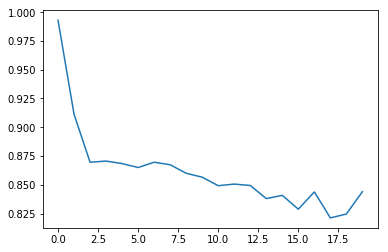

In [16]:
plt.plot([1 - i[2] for i in records])
right_ratio

### 3.迁移，不更新权重

在这个试验中，我们首先将识别器的卷积层的权重全部迁移到了加法机的两个卷积部件中，但保持它们的权重不变，只允许后面的全链接层的权重可训练。

In [17]:
net = Transfer()
# 迁移网络，并设置卷积部件的权重和偏置都不计算梯度
net.set_filter_values_nograd(original_net)
if use_cuda:
    net = net.cuda()
criterion = nn.MSELoss()

# 只将可更新的权重值加载到了优化器中
new_parameters = []
for para in net.parameters():
    if para.requires_grad:
        new_parameters.append(para)
optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)

In [18]:
# 训练整个网络
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net.train()
        optimizer.zero_grad()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
        labels = labels.type(dtype)
        loss = criterion(outputs, Variable(labels))
        loss.backward()

        optimizer.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.data.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(Variable(x1), Variable(x2))
                labels = y1 + y2
                loss = criterion(outputs, Variable(labels.type(dtype)))
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.data.numpy())
                
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
rights = []
net.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    outputs = net(Variable(x1), Variable(x2))
    labels = y1 + y2
    loss = criterion(outputs, Variable(labels.type(dtype)))
    right = rightness(outputs.data, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer_fixed'] = [records, right_ratio]    

第0周期，第(0/938)个撮，训练误差：75.82, 校验误差：89.67, 准确率：0.01
第1周期，第(0/938)个撮，训练误差：13.57, 校验误差：14.65, 准确率：0.09
第2周期，第(0/938)个撮，训练误差：11.05, 校验误差：10.09, 准确率：0.12
第3周期，第(0/938)个撮，训练误差：10.90, 校验误差：9.40, 准确率：0.12
第4周期，第(0/938)个撮，训练误差：11.77, 校验误差：8.21, 准确率：0.13
第5周期，第(0/938)个撮，训练误差：8.97, 校验误差：7.99, 准确率：0.13
第6周期，第(0/938)个撮，训练误差：8.17, 校验误差：7.62, 准确率：0.14
第7周期，第(0/938)个撮，训练误差：8.25, 校验误差：7.85, 准确率：0.14
第8周期，第(0/938)个撮，训练误差：5.61, 校验误差：7.24, 准确率：0.15
第9周期，第(0/938)个撮，训练误差：7.36, 校验误差：7.33, 准确率：0.16
第10周期，第(0/938)个撮，训练误差：7.88, 校验误差：8.58, 准确率：0.15
第11周期，第(0/938)个撮，训练误差：7.29, 校验误差：7.38, 准确率：0.15
第12周期，第(0/938)个撮，训练误差：6.35, 校验误差：6.64, 准确率：0.16
第13周期，第(0/938)个撮，训练误差：4.91, 校验误差：6.36, 准确率：0.17
第14周期，第(0/938)个撮，训练误差：6.27, 校验误差：6.05, 准确率：0.16
第15周期，第(0/938)个撮，训练误差：6.53, 校验误差：6.29, 准确率：0.17
第16周期，第(0/938)个撮，训练误差：4.71, 校验误差：6.17, 准确率：0.17
第17周期，第(0/938)个撮，训练误差：7.43, 校验误差：5.68, 准确率：0.17
第18周期，第(0/938)个撮，训练误差：10.01, 校验误差：5.93, 准确率：0.16
第19周期，第(0/938)个撮，训练误差：8.13, 校验误差：6.32, 准确率：0.19


0.22120000000000001

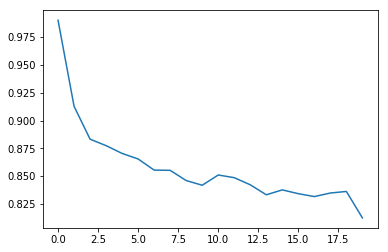

In [19]:
plt.plot([1 - i[2] for i in records])
right_ratio

### 4、结果比较
将三次实验的结果放到一起比较

In [20]:
y1, y2, y3 = results['notransfer'][0], results['transfer_pretrained'][0], results['transfer_fixed'][0]

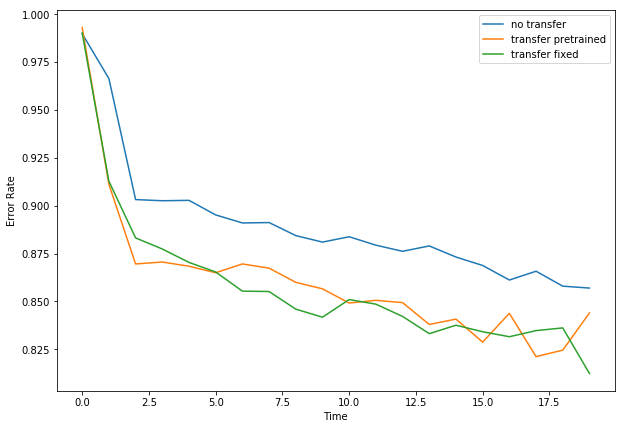

In [21]:
plt.figure(figsize = (10, 7))
plt.plot([1 - i[2] for i in y1], label = 'no transfer')
plt.plot([1 - i[2] for i in y2], label = 'transfer pretrained')
plt.plot([1 - i[2] for i in y3], label = 'transfer fixed')
plt.xlabel('Time')
plt.ylabel('Error Rate')
plt.legend()

In [22]:
results['notransfer'][1], results['transfer_pretrained'][1], results['transfer_fixed'][1]

(0.1668, 0.18179999999999999, 0.22120000000000001)

In [24]:
experiments = {}

In [25]:
experiments[1] = results

In [26]:
experiments

{1: {'notransfer': [[[103.17983, 96.370918, 0.010200000000000001],
    [73.741928, 61.790928, 0.033599999999999998],
    [20.267231, 16.867476, 0.096799999999999997],
    [13.607555, 15.843297, 0.0974],
    [14.450922, 15.201532, 0.097199999999999995],
    [18.488815, 14.903067, 0.1048],
    [10.283386, 14.086132, 0.109],
    [16.222244, 13.029918, 0.10879999999999999],
    [11.764784, 12.406302, 0.11559999999999999],
    [12.295241, 11.172582, 0.11899999999999999],
    [11.771688, 10.423013, 0.1162],
    [10.407387, 9.6798944, 0.1206],
    [8.3516321, 9.0615129, 0.12379999999999999],
    [7.9577279, 8.9829597, 0.121],
    [10.154799, 8.655755, 0.1268],
    [7.264215, 8.3946838, 0.13120000000000001],
    [8.7678776, 7.8224859, 0.13880000000000001],
    [7.0586815, 7.897234, 0.13420000000000001],
    [8.8404989, 7.4646282, 0.14199999999999999],
    [7.4753046, 7.0603204, 0.14299999999999999]],
   0.1668],
  'transfer_fixed': [[[75.823242, 89.665901, 0.0097999999999999997],
    [13.57398

## 综合试验

为了系统化的比较不同的参数对迁移学习的影响，我们做了一次大实验：

该试验包括了三重循环，分别是：

1、不同的迁移学习方法：无迁移、迁移固定权重、迁移预训练

2、每一个参数下重复实验times次

3、加载不同的数据集比例fraction

由于本试验需要消耗大量的计算时间，所以请慎重执行下面的语句。

In [27]:
results = {} #记载实验结果
times = 10 # 每一组参数下实验都要被重复10次
fractions = [20, 10, 8, 6, 5, 4, 3, 2, 1] #所有的数据加载的比例值
for experiment in ['no transfer', 'transfer_fixed', 'transfer_pretrained']:
    for time in range(times):
        for fraction in fractions:
            
            # 分不同的迁移学习情况加载网络和优化器
            if experiment == 'no transfer':
                net = Transfer()
                if use_cuda:
                    net = net.cuda()
                criterion = nn.MSELoss()
                optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)
            if experiment == 'transfer_pretrained':
                net = Transfer()
                net.set_filter_values(original_net)
                if use_cuda:
                    net = net.cuda()
                criterion = nn.MSELoss()
                new_parameters = []
                for para in net.parameters():
                    if para.requires_grad:
                        new_parameters.append(para)
                optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)
            if experiment == 'transfer_fixed':
                net = Transfer()
                net.set_filter_values_nograd(original_net)
                if use_cuda:
                    net = net.cuda()
                criterion = nn.MSELoss()
                new_parameters = []
                for para in net.parameters():
                    if para.requires_grad:
                        new_parameters.append(para)
                optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)
                
            #开始迁移学习训练
            num_epochs = 20
            records = []
            for epoch in range(num_epochs):
                losses = []
                for idx, data in enumerate(zip(train_loader1, train_loader2)):
                    if idx >= (len(train_loader1) // fraction):
                        break
                    ((x1, y1), (x2, y2)) = data
                    if use_cuda:
                        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                    net.train()
                    optimizer.zero_grad()
                    outputs = net(Variable(x1), Variable(x2))
                    labels = y1 + y2
                    loss = criterion(outputs, Variable(labels.type(dtype)))
                    loss.backward()
                    optimizer.step()
                    loss = loss.cpu() if use_cuda else loss
                    losses.append(loss.data.numpy())
                    if idx % 500 == 0:
                        val_losses = []
                        rights = []
                        net.eval()
                        for val_data in zip(val_loader1, val_loader2):
                            ((x1, y1), (x2, y2)) = val_data
                            if use_cuda:
                                x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                            outputs = net(Variable(x1), Variable(x2))
                            labels = y1 + y2
                            loss = criterion(outputs, Variable(labels.type(dtype)))
                            loss = loss.cpu() if use_cuda else loss
                            val_losses.append(loss.data.numpy())
                            right = rightness(outputs.data, labels)
                            rights.append(right)
                        right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
                        print('{}网络：第{}试验，比例{}, 第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'
                              .format(experiment,time,fraction,
                            epoch, idx, len(train_loader1),
                            np.mean(losses), np.mean(val_losses), right_ratio))
                        records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            rights = []
            net.eval()
            for test_data in zip(test_loader1, test_loader2):
                ((x1, y1), (x2, y2)) = test_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(Variable(x1), Variable(x2))
                labels = y1 + y2
                loss = criterion(outputs, Variable(labels.type(dtype)))
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print(experiment,time,fraction)
            
            #将结果记录在了results集合之中，records记载了每一个打印周期的训练集损失函数、校验集损失函数、校验集正确率，
            #right_ratio记录了每次实验测试集的准确度
            results[(experiment,time,fraction)] = [records, right_ratio]  

no transfer网络：第0试验，比例20, 第0周期，第(0/938)个撮，训练误差：91.90, 校验误差：100.30, 准确率：0.01
no transfer网络：第0试验，比例20, 第1周期，第(0/938)个撮，训练误差：84.02, 校验误差：79.25, 准确率：0.02
no transfer网络：第0试验，比例20, 第2周期，第(0/938)个撮，训练误差：17.59, 校验误差：16.20, 准确率：0.10
no transfer网络：第0试验，比例20, 第3周期，第(0/938)个撮，训练误差：11.65, 校验误差：15.21, 准确率：0.10
no transfer网络：第0试验，比例20, 第4周期，第(0/938)个撮，训练误差：15.15, 校验误差：14.15, 准确率：0.11
no transfer网络：第0试验，比例20, 第5周期，第(0/938)个撮，训练误差：9.88, 校验误差：13.23, 准确率：0.11
no transfer网络：第0试验，比例20, 第6周期，第(0/938)个撮，训练误差：11.62, 校验误差：12.36, 准确率：0.11
no transfer网络：第0试验，比例20, 第7周期，第(0/938)个撮，训练误差：13.78, 校验误差：10.79, 准确率：0.11
no transfer网络：第0试验，比例20, 第8周期，第(0/938)个撮，训练误差：8.12, 校验误差：9.21, 准确率：0.12
no transfer网络：第0试验，比例20, 第9周期，第(0/938)个撮，训练误差：10.28, 校验误差：8.65, 准确率：0.12
no transfer网络：第0试验，比例20, 第10周期，第(0/938)个撮，训练误差：8.27, 校验误差：8.39, 准确率：0.13
no transfer网络：第0试验，比例20, 第11周期，第(0/938)个撮，训练误差：7.84, 校验误差：7.78, 准确率：0.13
no transfer网络：第0试验，比例20, 第12周期，第(0/938)个撮，训练误差：8.59, 校验误差：7.42, 准确率：0.14
no transfer网络：第0试验，比例20, 第13周期，第(0/938)个撮，训练

no transfer网络：第0试验，比例4, 第13周期，第(0/938)个撮，训练误差：3.11, 校验误差：3.67, 准确率：0.24
no transfer网络：第0试验，比例4, 第14周期，第(0/938)个撮，训练误差：5.53, 校验误差：3.47, 准确率：0.24
no transfer网络：第0试验，比例4, 第15周期，第(0/938)个撮，训练误差：3.21, 校验误差：3.21, 准确率：0.24
no transfer网络：第0试验，比例4, 第16周期，第(0/938)个撮，训练误差：3.60, 校验误差：3.55, 准确率：0.22
no transfer网络：第0试验，比例4, 第17周期，第(0/938)个撮，训练误差：2.76, 校验误差：3.13, 准确率：0.26
no transfer网络：第0试验，比例4, 第18周期，第(0/938)个撮，训练误差：3.38, 校验误差：3.58, 准确率：0.20
no transfer网络：第0试验，比例4, 第19周期，第(0/938)个撮，训练误差：1.71, 校验误差：3.04, 准确率：0.27
no transfer 0 4
no transfer网络：第0试验，比例3, 第0周期，第(0/938)个撮，训练误差：91.02, 校验误差：94.31, 准确率：0.01
no transfer网络：第0试验，比例3, 第1周期，第(0/938)个撮，训练误差：11.92, 校验误差：14.00, 准确率：0.10
no transfer网络：第0试验，比例3, 第2周期，第(0/938)个撮，训练误差：6.34, 校验误差：7.87, 准确率：0.13
no transfer网络：第0试验，比例3, 第3周期，第(0/938)个撮，训练误差：5.12, 校验误差：6.09, 准确率：0.16
no transfer网络：第0试验，比例3, 第4周期，第(0/938)个撮，训练误差：5.24, 校验误差：5.30, 准确率：0.18
no transfer网络：第0试验，比例3, 第5周期，第(0/938)个撮，训练误差：3.51, 校验误差：5.07, 准确率：0.18
no transfer网络：第0试验，比例3, 第6周期，第(0/938)个撮，训练误差：4.09,

no transfer网络：第1试验，比例10, 第5周期，第(0/938)个撮，训练误差：9.30, 校验误差：10.11, 准确率：0.12
no transfer网络：第1试验，比例10, 第6周期，第(0/938)个撮，训练误差：7.15, 校验误差：8.45, 准确率：0.13
no transfer网络：第1试验，比例10, 第7周期，第(0/938)个撮，训练误差：7.87, 校验误差：7.63, 准确率：0.13
no transfer网络：第1试验，比例10, 第8周期，第(0/938)个撮，训练误差：5.08, 校验误差：6.94, 准确率：0.15
no transfer网络：第1试验，比例10, 第9周期，第(0/938)个撮，训练误差：5.56, 校验误差：6.18, 准确率：0.16
no transfer网络：第1试验，比例10, 第10周期，第(0/938)个撮，训练误差：4.78, 校验误差：6.10, 准确率：0.16
no transfer网络：第1试验，比例10, 第11周期，第(0/938)个撮，训练误差：4.93, 校验误差：5.63, 准确率：0.16
no transfer网络：第1试验，比例10, 第12周期，第(0/938)个撮，训练误差：4.65, 校验误差：5.46, 准确率：0.17
no transfer网络：第1试验，比例10, 第13周期，第(0/938)个撮，训练误差：5.85, 校验误差：5.10, 准确率：0.18
no transfer网络：第1试验，比例10, 第14周期，第(0/938)个撮，训练误差：6.58, 校验误差：4.96, 准确率：0.18
no transfer网络：第1试验，比例10, 第15周期，第(0/938)个撮，训练误差：5.36, 校验误差：4.83, 准确率：0.19
no transfer网络：第1试验，比例10, 第16周期，第(0/938)个撮，训练误差：4.68, 校验误差：4.75, 准确率：0.19
no transfer网络：第1试验，比例10, 第17周期，第(0/938)个撮，训练误差：3.13, 校验误差：4.88, 准确率：0.19
no transfer网络：第1试验，比例10, 第18周期，第(0/938)个撮，训练误差：4.15, 校验

no transfer网络：第1试验，比例3, 第18周期，第(0/938)个撮，训练误差：2.75, 校验误差：2.76, 准确率：0.30
no transfer网络：第1试验，比例3, 第19周期，第(0/938)个撮，训练误差：1.98, 校验误差：2.81, 准确率：0.28
no transfer 1 3
no transfer网络：第1试验，比例2, 第0周期，第(0/938)个撮，训练误差：111.48, 校验误差：100.85, 准确率：0.01
no transfer网络：第1试验，比例2, 第1周期，第(0/938)个撮，训练误差：7.99, 校验误差：9.43, 准确率：0.13
no transfer网络：第1试验，比例2, 第2周期，第(0/938)个撮，训练误差：4.95, 校验误差：6.27, 准确率：0.16
no transfer网络：第1试验，比例2, 第3周期，第(0/938)个撮，训练误差：3.69, 校验误差：4.86, 准确率：0.18
no transfer网络：第1试验，比例2, 第4周期，第(0/938)个撮，训练误差：4.43, 校验误差：4.26, 准确率：0.20
no transfer网络：第1试验，比例2, 第5周期，第(0/938)个撮，训练误差：3.53, 校验误差：3.72, 准确率：0.24
no transfer网络：第1试验，比例2, 第6周期，第(0/938)个撮，训练误差：3.77, 校验误差：3.40, 准确率：0.25
no transfer网络：第1试验，比例2, 第7周期，第(0/938)个撮，训练误差：2.96, 校验误差：3.15, 准确率：0.25
no transfer网络：第1试验，比例2, 第8周期，第(0/938)个撮，训练误差：3.49, 校验误差：2.96, 准确率：0.26
no transfer网络：第1试验，比例2, 第9周期，第(0/938)个撮，训练误差：3.30, 校验误差：2.92, 准确率：0.29
no transfer网络：第1试验，比例2, 第10周期，第(0/938)个撮，训练误差：2.75, 校验误差：3.17, 准确率：0.28
no transfer网络：第1试验，比例2, 第11周期，第(0/938)个撮，训练误差：3.08, 校验

no transfer网络：第2试验，比例8, 第10周期，第(0/938)个撮，训练误差：5.66, 校验误差：5.34, 准确率：0.17
no transfer网络：第2试验，比例8, 第11周期，第(0/938)个撮，训练误差：4.82, 校验误差：5.42, 准确率：0.17
no transfer网络：第2试验，比例8, 第12周期，第(0/938)个撮，训练误差：6.73, 校验误差：5.15, 准确率：0.18
no transfer网络：第2试验，比例8, 第13周期，第(0/938)个撮，训练误差：4.85, 校验误差：4.98, 准确率：0.19
no transfer网络：第2试验，比例8, 第14周期，第(0/938)个撮，训练误差：4.73, 校验误差：4.78, 准确率：0.20
no transfer网络：第2试验，比例8, 第15周期，第(0/938)个撮，训练误差：4.20, 校验误差：4.61, 准确率：0.20
no transfer网络：第2试验，比例8, 第16周期，第(0/938)个撮，训练误差：5.09, 校验误差：4.39, 准确率：0.21
no transfer网络：第2试验，比例8, 第17周期，第(0/938)个撮，训练误差：4.69, 校验误差：4.25, 准确率：0.21
no transfer网络：第2试验，比例8, 第18周期，第(0/938)个撮，训练误差：3.38, 校验误差：4.20, 准确率：0.20
no transfer网络：第2试验，比例8, 第19周期，第(0/938)个撮，训练误差：3.45, 校验误差：4.14, 准确率：0.22
no transfer 2 8
no transfer网络：第2试验，比例6, 第0周期，第(0/938)个撮，训练误差：79.91, 校验误差：99.61, 准确率：0.01
no transfer网络：第2试验，比例6, 第1周期，第(0/938)个撮，训练误差：17.39, 校验误差：15.08, 准确率：0.10
no transfer网络：第2试验，比例6, 第2周期，第(0/938)个撮，训练误差：14.49, 校验误差：11.96, 准确率：0.12
no transfer网络：第2试验，比例6, 第3周期，第(0/938)个撮，训练误差：

no transfer网络：第2试验，比例1, 第1周期，第(500/938)个撮，训练误差：5.37, 校验误差：4.89, 准确率：0.19
no transfer网络：第2试验，比例1, 第2周期，第(0/938)个撮，训练误差：4.24, 校验误差：4.37, 准确率：0.20
no transfer网络：第2试验，比例1, 第2周期，第(500/938)个撮，训练误差：3.94, 校验误差：3.73, 准确率：0.23
no transfer网络：第2试验，比例1, 第3周期，第(0/938)个撮，训练误差：2.49, 校验误差：3.46, 准确率：0.24
no transfer网络：第2试验，比例1, 第3周期，第(500/938)个撮，训练误差：3.26, 校验误差：3.30, 准确率：0.26
no transfer网络：第2试验，比例1, 第4周期，第(0/938)个撮，训练误差：1.76, 校验误差：3.09, 准确率：0.27
no transfer网络：第2试验，比例1, 第4周期，第(500/938)个撮，训练误差：2.88, 校验误差：2.79, 准确率：0.29
no transfer网络：第2试验，比例1, 第5周期，第(0/938)个撮，训练误差：2.50, 校验误差：2.78, 准确率：0.28
no transfer网络：第2试验，比例1, 第5周期，第(500/938)个撮，训练误差：2.63, 校验误差：2.75, 准确率：0.28
no transfer网络：第2试验，比例1, 第6周期，第(0/938)个撮，训练误差：2.27, 校验误差：2.44, 准确率：0.32
no transfer网络：第2试验，比例1, 第6周期，第(500/938)个撮，训练误差：2.40, 校验误差：2.44, 准确率：0.31
no transfer网络：第2试验，比例1, 第7周期，第(0/938)个撮，训练误差：3.19, 校验误差：2.34, 准确率：0.32
no transfer网络：第2试验，比例1, 第7周期，第(500/938)个撮，训练误差：2.25, 校验误差：2.35, 准确率：0.34
no transfer网络：第2试验，比例1, 第8周期，第(0/938)个撮，训练误差：2.19, 校验误差：2.34, 准

no transfer网络：第3试验，比例6, 第15周期，第(0/938)个撮，训练误差：3.27, 校验误差：4.45, 准确率：0.20
no transfer网络：第3试验，比例6, 第16周期，第(0/938)个撮，训练误差：2.90, 校验误差：4.22, 准确率：0.21
no transfer网络：第3试验，比例6, 第17周期，第(0/938)个撮，训练误差：3.63, 校验误差：4.21, 准确率：0.21
no transfer网络：第3试验，比例6, 第18周期，第(0/938)个撮，训练误差：3.08, 校验误差：3.94, 准确率：0.22
no transfer网络：第3试验，比例6, 第19周期，第(0/938)个撮，训练误差：4.44, 校验误差：4.07, 准确率：0.21
no transfer 3 6
no transfer网络：第3试验，比例5, 第0周期，第(0/938)个撮，训练误差：82.45, 校验误差：98.06, 准确率：0.01
no transfer网络：第3试验，比例5, 第1周期，第(0/938)个撮，训练误差：12.24, 校验误差：15.78, 准确率：0.10
no transfer网络：第3试验，比例5, 第2周期，第(0/938)个撮，训练误差：9.91, 校验误差：10.71, 准确率：0.12
no transfer网络：第3试验，比例5, 第3周期，第(0/938)个撮，训练误差：7.34, 校验误差：8.38, 准确率：0.13
no transfer网络：第3试验，比例5, 第4周期，第(0/938)个撮，训练误差：5.36, 校验误差：7.03, 准确率：0.14
no transfer网络：第3试验，比例5, 第5周期，第(0/938)个撮，训练误差：4.42, 校验误差：6.12, 准确率：0.16
no transfer网络：第3试验，比例5, 第6周期，第(0/938)个撮，训练误差：8.83, 校验误差：5.51, 准确率：0.17
no transfer网络：第3试验，比例5, 第7周期，第(0/938)个撮，训练误差：4.40, 校验误差：5.21, 准确率：0.17
no transfer网络：第3试验，比例5, 第8周期，第(0/938)个撮，训练误差：4.94, 

no transfer网络：第3试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.42, 校验误差：1.89, 准确率：0.37
no transfer网络：第3试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.79, 校验误差：1.88, 准确率：0.38
no transfer网络：第3试验，比例1, 第15周期，第(0/938)个撮，训练误差：1.13, 校验误差：1.84, 准确率：0.38
no transfer网络：第3试验，比例1, 第15周期，第(500/938)个撮，训练误差：1.72, 校验误差：1.83, 准确率：0.39
no transfer网络：第3试验，比例1, 第16周期，第(0/938)个撮，训练误差：2.13, 校验误差：1.81, 准确率：0.39
no transfer网络：第3试验，比例1, 第16周期，第(500/938)个撮，训练误差：1.68, 校验误差：1.74, 准确率：0.41
no transfer网络：第3试验，比例1, 第17周期，第(0/938)个撮，训练误差：1.53, 校验误差：1.74, 准确率：0.39
no transfer网络：第3试验，比例1, 第17周期，第(500/938)个撮，训练误差：1.59, 校验误差：1.79, 准确率：0.40
no transfer网络：第3试验，比例1, 第18周期，第(0/938)个撮，训练误差：1.47, 校验误差：1.67, 准确率：0.41
no transfer网络：第3试验，比例1, 第18周期，第(500/938)个撮，训练误差：1.56, 校验误差：1.74, 准确率：0.42
no transfer网络：第3试验，比例1, 第19周期，第(0/938)个撮，训练误差：1.83, 校验误差：1.68, 准确率：0.39
no transfer网络：第3试验，比例1, 第19周期，第(500/938)个撮，训练误差：1.54, 校验误差：1.75, 准确率：0.41
no transfer 3 1
no transfer网络：第4试验，比例20, 第0周期，第(0/938)个撮，训练误差：105.60, 校验误差：93.43, 准确率：0.01
no transfer网络：第4试验，比例20, 第1周期，第(0

no transfer 4 5
no transfer网络：第4试验，比例4, 第0周期，第(0/938)个撮，训练误差：106.62, 校验误差：100.92, 准确率：0.01
no transfer网络：第4试验，比例4, 第1周期，第(0/938)个撮，训练误差：15.47, 校验误差：15.95, 准确率：0.10
no transfer网络：第4试验，比例4, 第2周期，第(0/938)个撮，训练误差：10.75, 校验误差：10.92, 准确率：0.12
no transfer网络：第4试验，比例4, 第3周期，第(0/938)个撮，训练误差：8.67, 校验误差：8.59, 准确率：0.12
no transfer网络：第4试验，比例4, 第4周期，第(0/938)个撮，训练误差：5.30, 校验误差：7.16, 准确率：0.14
no transfer网络：第4试验，比例4, 第5周期，第(0/938)个撮，训练误差：7.05, 校验误差：6.12, 准确率：0.16
no transfer网络：第4试验，比例4, 第6周期，第(0/938)个撮，训练误差：4.78, 校验误差：5.28, 准确率：0.17
no transfer网络：第4试验，比例4, 第7周期，第(0/938)个撮，训练误差：4.97, 校验误差：5.08, 准确率：0.17
no transfer网络：第4试验，比例4, 第8周期，第(0/938)个撮，训练误差：4.58, 校验误差：4.63, 准确率：0.19
no transfer网络：第4试验，比例4, 第9周期，第(0/938)个撮，训练误差：4.57, 校验误差：4.38, 准确率：0.20
no transfer网络：第4试验，比例4, 第10周期，第(0/938)个撮，训练误差：2.94, 校验误差：4.18, 准确率：0.19
no transfer网络：第4试验，比例4, 第11周期，第(0/938)个撮，训练误差：5.43, 校验误差：3.82, 准确率：0.23
no transfer网络：第4试验，比例4, 第12周期，第(0/938)个撮，训练误差：2.31, 校验误差：3.67, 准确率：0.23
no transfer网络：第4试验，比例4, 第13周期，第(0/938)个撮，训练误差：3.72

no transfer网络：第5试验，比例20, 第13周期，第(0/938)个撮，训练误差：10.10, 校验误差：8.61, 准确率：0.12
no transfer网络：第5试验，比例20, 第14周期，第(0/938)个撮，训练误差：7.71, 校验误差：7.91, 准确率：0.13
no transfer网络：第5试验，比例20, 第15周期，第(0/938)个撮，训练误差：6.96, 校验误差：7.88, 准确率：0.13
no transfer网络：第5试验，比例20, 第16周期，第(0/938)个撮，训练误差：7.43, 校验误差：7.27, 准确率：0.15
no transfer网络：第5试验，比例20, 第17周期，第(0/938)个撮，训练误差：7.50, 校验误差：7.45, 准确率：0.14
no transfer网络：第5试验，比例20, 第18周期，第(0/938)个撮，训练误差：7.62, 校验误差：6.61, 准确率：0.15
no transfer网络：第5试验，比例20, 第19周期，第(0/938)个撮，训练误差：5.85, 校验误差：6.21, 准确率：0.15
no transfer 5 20
no transfer网络：第5试验，比例10, 第0周期，第(0/938)个撮，训练误差：91.98, 校验误差：90.38, 准确率：0.01
no transfer网络：第5试验，比例10, 第1周期，第(0/938)个撮，训练误差：17.43, 校验误差：16.39, 准确率：0.10
no transfer网络：第5试验，比例10, 第2周期，第(0/938)个撮，训练误差：16.03, 校验误差：15.56, 准确率：0.10
no transfer网络：第5试验，比例10, 第3周期，第(0/938)个撮，训练误差：13.69, 校验误差：14.33, 准确率：0.11
no transfer网络：第5试验，比例10, 第4周期，第(0/938)个撮，训练误差：10.98, 校验误差：11.18, 准确率：0.12
no transfer网络：第5试验，比例10, 第5周期，第(0/938)个撮，训练误差：9.22, 校验误差：9.31, 准确率：0.12
no transfer网络：第5试验，比例10, 第6周期

no transfer网络：第5试验，比例3, 第6周期，第(0/938)个撮，训练误差：4.11, 校验误差：4.68, 准确率：0.20
no transfer网络：第5试验，比例3, 第7周期，第(0/938)个撮，训练误差：5.54, 校验误差：4.23, 准确率：0.21
no transfer网络：第5试验，比例3, 第8周期，第(0/938)个撮，训练误差：4.07, 校验误差：4.02, 准确率：0.22
no transfer网络：第5试验，比例3, 第9周期，第(0/938)个撮，训练误差：3.40, 校验误差：3.69, 准确率：0.23
no transfer网络：第5试验，比例3, 第10周期，第(0/938)个撮，训练误差：4.03, 校验误差：3.67, 准确率：0.24
no transfer网络：第5试验，比例3, 第11周期，第(0/938)个撮，训练误差：2.66, 校验误差：3.33, 准确率：0.24
no transfer网络：第5试验，比例3, 第12周期，第(0/938)个撮，训练误差：3.08, 校验误差：3.26, 准确率：0.26
no transfer网络：第5试验，比例3, 第13周期，第(0/938)个撮，训练误差：1.96, 校验误差：3.10, 准确率：0.28
no transfer网络：第5试验，比例3, 第14周期，第(0/938)个撮，训练误差：1.39, 校验误差：2.97, 准确率：0.28
no transfer网络：第5试验，比例3, 第15周期，第(0/938)个撮，训练误差：2.85, 校验误差：2.87, 准确率：0.26
no transfer网络：第5试验，比例3, 第16周期，第(0/938)个撮，训练误差：3.06, 校验误差：2.76, 准确率：0.28
no transfer网络：第5试验，比例3, 第17周期，第(0/938)个撮，训练误差：2.11, 校验误差：2.68, 准确率：0.29
no transfer网络：第5试验，比例3, 第18周期，第(0/938)个撮，训练误差：2.28, 校验误差：2.64, 准确率：0.30
no transfer网络：第5试验，比例3, 第19周期，第(0/938)个撮，训练误差：2.94, 校验误差：2.56, 准确率：0

no transfer网络：第6试验，比例10, 第18周期，第(0/938)个撮，训练误差：4.37, 校验误差：4.98, 准确率：0.19
no transfer网络：第6试验，比例10, 第19周期，第(0/938)个撮，训练误差：4.40, 校验误差：4.80, 准确率：0.18
no transfer 6 10
no transfer网络：第6试验，比例8, 第0周期，第(0/938)个撮，训练误差：92.77, 校验误差：93.13, 准确率：0.01
no transfer网络：第6试验，比例8, 第1周期，第(0/938)个撮，训练误差：13.76, 校验误差：16.39, 准确率：0.09
no transfer网络：第6试验，比例8, 第2周期，第(0/938)个撮，训练误差：19.41, 校验误差：14.96, 准确率：0.10
no transfer网络：第6试验，比例8, 第3周期，第(0/938)个撮，训练误差：12.12, 校验误差：13.69, 准确率：0.09
no transfer网络：第6试验，比例8, 第4周期，第(0/938)个撮，训练误差：12.79, 校验误差：11.51, 准确率：0.11
no transfer网络：第6试验，比例8, 第5周期，第(0/938)个撮，训练误差：8.69, 校验误差：9.29, 准确率：0.13
no transfer网络：第6试验，比例8, 第6周期，第(0/938)个撮，训练误差：7.50, 校验误差：8.13, 准确率：0.13
no transfer网络：第6试验，比例8, 第7周期，第(0/938)个撮，训练误差：7.46, 校验误差：7.21, 准确率：0.14
no transfer网络：第6试验，比例8, 第8周期，第(0/938)个撮，训练误差：7.96, 校验误差：6.60, 准确率：0.15
no transfer网络：第6试验，比例8, 第9周期，第(0/938)个撮，训练误差：6.02, 校验误差：6.38, 准确率：0.15
no transfer网络：第6试验，比例8, 第10周期，第(0/938)个撮，训练误差：8.00, 校验误差：6.03, 准确率：0.16
no transfer网络：第6试验，比例8, 第11周期，第(0/938)个撮，训练误差

no transfer网络：第6试验，比例2, 第11周期，第(0/938)个撮，训练误差：2.38, 校验误差：2.71, 准确率：0.29
no transfer网络：第6试验，比例2, 第12周期，第(0/938)个撮，训练误差：2.50, 校验误差：2.66, 准确率：0.30
no transfer网络：第6试验，比例2, 第13周期，第(0/938)个撮，训练误差：2.73, 校验误差：2.65, 准确率：0.29
no transfer网络：第6试验，比例2, 第14周期，第(0/938)个撮，训练误差：2.09, 校验误差：2.51, 准确率：0.30
no transfer网络：第6试验，比例2, 第15周期，第(0/938)个撮，训练误差：1.39, 校验误差：2.51, 准确率：0.32
no transfer网络：第6试验，比例2, 第16周期，第(0/938)个撮，训练误差：1.99, 校验误差：2.29, 准确率：0.32
no transfer网络：第6试验，比例2, 第17周期，第(0/938)个撮，训练误差：2.44, 校验误差：2.25, 准确率：0.31
no transfer网络：第6试验，比例2, 第18周期，第(0/938)个撮，训练误差：1.70, 校验误差：2.18, 准确率：0.32
no transfer网络：第6试验，比例2, 第19周期，第(0/938)个撮，训练误差：2.20, 校验误差：2.22, 准确率：0.30
no transfer 6 2
no transfer网络：第6试验，比例1, 第0周期，第(0/938)个撮，训练误差：86.39, 校验误差：95.72, 准确率：0.01
no transfer网络：第6试验，比例1, 第0周期，第(500/938)个撮，训练误差：26.72, 校验误差：9.44, 准确率：0.12
no transfer网络：第6试验，比例1, 第1周期，第(0/938)个撮，训练误差：6.72, 校验误差：5.99, 准确率：0.16
no transfer网络：第6试验，比例1, 第1周期，第(500/938)个撮，训练误差：5.20, 校验误差：4.88, 准确率：0.18
no transfer网络：第6试验，比例1, 第2周期，第(0/938)个撮，训练误差：

no transfer网络：第7试验，比例6, 第3周期，第(0/938)个撮，训练误差：6.98, 校验误差：8.66, 准确率：0.14
no transfer网络：第7试验，比例6, 第4周期，第(0/938)个撮，训练误差：6.51, 校验误差：7.35, 准确率：0.15
no transfer网络：第7试验，比例6, 第5周期，第(0/938)个撮，训练误差：6.04, 校验误差：6.30, 准确率：0.16
no transfer网络：第7试验，比例6, 第6周期，第(0/938)个撮，训练误差：4.50, 校验误差：5.98, 准确率：0.17
no transfer网络：第7试验，比例6, 第7周期，第(0/938)个撮，训练误差：4.86, 校验误差：5.62, 准确率：0.17
no transfer网络：第7试验，比例6, 第8周期，第(0/938)个撮，训练误差：5.10, 校验误差：5.23, 准确率：0.18
no transfer网络：第7试验，比例6, 第9周期，第(0/938)个撮，训练误差：4.24, 校验误差：5.10, 准确率：0.19
no transfer网络：第7试验，比例6, 第10周期，第(0/938)个撮，训练误差：4.60, 校验误差：4.52, 准确率：0.20
no transfer网络：第7试验，比例6, 第11周期，第(0/938)个撮，训练误差：5.47, 校验误差：4.40, 准确率：0.21
no transfer网络：第7试验，比例6, 第12周期，第(0/938)个撮，训练误差：5.61, 校验误差：4.37, 准确率：0.20
no transfer网络：第7试验，比例6, 第13周期，第(0/938)个撮，训练误差：3.50, 校验误差：4.16, 准确率：0.22
no transfer网络：第7试验，比例6, 第14周期，第(0/938)个撮，训练误差：5.63, 校验误差：4.25, 准确率：0.22
no transfer网络：第7试验，比例6, 第15周期，第(0/938)个撮，训练误差：4.02, 校验误差：3.95, 准确率：0.23
no transfer网络：第7试验，比例6, 第16周期，第(0/938)个撮，训练误差：3.48, 校验误差：3.75, 准确率：0.21

no transfer网络：第7试验，比例1, 第8周期，第(0/938)个撮，训练误差：1.57, 校验误差：2.61, 准确率：0.30
no transfer网络：第7试验，比例1, 第8周期，第(500/938)个撮，训练误差：2.27, 校验误差：2.33, 准确率：0.32
no transfer网络：第7试验，比例1, 第9周期，第(0/938)个撮，训练误差：2.31, 校验误差：2.19, 准确率：0.33
no transfer网络：第7试验，比例1, 第9周期，第(500/938)个撮，训练误差：2.12, 校验误差：2.20, 准确率：0.34
no transfer网络：第7试验，比例1, 第10周期，第(0/938)个撮，训练误差：1.79, 校验误差：2.12, 准确率：0.34
no transfer网络：第7试验，比例1, 第10周期，第(500/938)个撮，训练误差：2.07, 校验误差：2.08, 准确率：0.35
no transfer网络：第7试验，比例1, 第11周期，第(0/938)个撮，训练误差：2.35, 校验误差：2.04, 准确率：0.35
no transfer网络：第7试验，比例1, 第11周期，第(500/938)个撮，训练误差：1.96, 校验误差：2.05, 准确率：0.36
no transfer网络：第7试验，比例1, 第12周期，第(0/938)个撮，训练误差：2.15, 校验误差：1.98, 准确率：0.36
no transfer网络：第7试验，比例1, 第12周期，第(500/938)个撮，训练误差：1.90, 校验误差：1.96, 准确率：0.36
no transfer网络：第7试验，比例1, 第13周期，第(0/938)个撮，训练误差：1.68, 校验误差：1.88, 准确率：0.38
no transfer网络：第7试验，比例1, 第13周期，第(500/938)个撮，训练误差：1.83, 校验误差：1.90, 准确率：0.36
no transfer网络：第7试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.58, 校验误差：1.86, 准确率：0.39
no transfer网络：第7试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.77, 校验

no transfer网络：第8试验，比例5, 第8周期，第(0/938)个撮，训练误差：5.02, 校验误差：4.98, 准确率：0.18
no transfer网络：第8试验，比例5, 第9周期，第(0/938)个撮，训练误差：3.26, 校验误差：4.44, 准确率：0.20
no transfer网络：第8试验，比例5, 第10周期，第(0/938)个撮，训练误差：4.80, 校验误差：4.42, 准确率：0.19
no transfer网络：第8试验，比例5, 第11周期，第(0/938)个撮，训练误差：4.49, 校验误差：4.12, 准确率：0.20
no transfer网络：第8试验，比例5, 第12周期，第(0/938)个撮，训练误差：2.55, 校验误差：4.04, 准确率：0.22
no transfer网络：第8试验，比例5, 第13周期，第(0/938)个撮，训练误差：2.98, 校验误差：3.92, 准确率：0.22
no transfer网络：第8试验，比例5, 第14周期，第(0/938)个撮，训练误差：4.31, 校验误差：3.72, 准确率：0.23
no transfer网络：第8试验，比例5, 第15周期，第(0/938)个撮，训练误差：4.38, 校验误差：3.48, 准确率：0.23
no transfer网络：第8试验，比例5, 第16周期，第(0/938)个撮，训练误差：2.76, 校验误差：3.58, 准确率：0.24
no transfer网络：第8试验，比例5, 第17周期，第(0/938)个撮，训练误差：3.84, 校验误差：3.33, 准确率：0.25
no transfer网络：第8试验，比例5, 第18周期，第(0/938)个撮，训练误差：3.62, 校验误差：3.33, 准确率：0.23
no transfer网络：第8试验，比例5, 第19周期，第(0/938)个撮，训练误差：2.76, 校验误差：3.26, 准确率：0.24
no transfer 8 5
no transfer网络：第8试验，比例4, 第0周期，第(0/938)个撮，训练误差：100.63, 校验误差：101.10, 准确率：0.01
no transfer网络：第8试验，比例4, 第1周期，第(0/938)个撮，训练误差：15

no transfer网络：第9试验，比例20, 第1周期，第(0/938)个撮，训练误差：81.16, 校验误差：85.01, 准确率：0.02
no transfer网络：第9试验，比例20, 第2周期，第(0/938)个撮，训练误差：21.18, 校验误差：22.05, 准确率：0.09
no transfer网络：第9试验，比例20, 第3周期，第(0/938)个撮，训练误差：18.14, 校验误差：15.82, 准确率：0.10
no transfer网络：第9试验，比例20, 第4周期，第(0/938)个撮，训练误差：15.88, 校验误差：16.36, 准确率：0.10
no transfer网络：第9试验，比例20, 第5周期，第(0/938)个撮，训练误差：12.96, 校验误差：15.73, 准确率：0.10
no transfer网络：第9试验，比例20, 第6周期，第(0/938)个撮，训练误差：17.18, 校验误差：15.82, 准确率：0.10
no transfer网络：第9试验，比例20, 第7周期，第(0/938)个撮，训练误差：13.11, 校验误差：14.80, 准确率：0.10
no transfer网络：第9试验，比例20, 第8周期，第(0/938)个撮，训练误差：16.29, 校验误差：14.54, 准确率：0.10
no transfer网络：第9试验，比例20, 第9周期，第(0/938)个撮，训练误差：12.41, 校验误差：13.15, 准确率：0.11
no transfer网络：第9试验，比例20, 第10周期，第(0/938)个撮，训练误差：9.93, 校验误差：12.17, 准确率：0.11
no transfer网络：第9试验，比例20, 第11周期，第(0/938)个撮，训练误差：8.52, 校验误差：10.29, 准确率：0.12
no transfer网络：第9试验，比例20, 第12周期，第(0/938)个撮，训练误差：6.83, 校验误差：9.47, 准确率：0.12
no transfer网络：第9试验，比例20, 第13周期，第(0/938)个撮，训练误差：11.19, 校验误差：9.70, 准确率：0.12
no transfer网络：第9试验，比例20, 第14周期，第(0/938)

no transfer网络：第9试验，比例4, 第14周期，第(0/938)个撮，训练误差：3.66, 校验误差：3.29, 准确率：0.25
no transfer网络：第9试验，比例4, 第15周期，第(0/938)个撮，训练误差：2.78, 校验误差：3.33, 准确率：0.24
no transfer网络：第9试验，比例4, 第16周期，第(0/938)个撮，训练误差：2.49, 校验误差：3.27, 准确率：0.23
no transfer网络：第9试验，比例4, 第17周期，第(0/938)个撮，训练误差：1.64, 校验误差：3.10, 准确率：0.27
no transfer网络：第9试验，比例4, 第18周期，第(0/938)个撮，训练误差：4.08, 校验误差：3.01, 准确率：0.28
no transfer网络：第9试验，比例4, 第19周期，第(0/938)个撮，训练误差：2.97, 校验误差：3.05, 准确率：0.27
no transfer 9 4
no transfer网络：第9试验，比例3, 第0周期，第(0/938)个撮，训练误差：103.26, 校验误差：90.90, 准确率：0.01
no transfer网络：第9试验，比例3, 第1周期，第(0/938)个撮，训练误差：15.75, 校验误差：14.82, 准确率：0.10
no transfer网络：第9试验，比例3, 第2周期，第(0/938)个撮，训练误差：8.35, 校验误差：8.04, 准确率：0.14
no transfer网络：第9试验，比例3, 第3周期，第(0/938)个撮，训练误差：6.10, 校验误差：6.50, 准确率：0.16
no transfer网络：第9试验，比例3, 第4周期，第(0/938)个撮，训练误差：6.23, 校验误差：5.68, 准确率：0.16
no transfer网络：第9试验，比例3, 第5周期，第(0/938)个撮，训练误差：4.74, 校验误差：5.08, 准确率：0.19
no transfer网络：第9试验，比例3, 第6周期，第(0/938)个撮，训练误差：4.24, 校验误差：4.67, 准确率：0.19
no transfer网络：第9试验，比例3, 第7周期，第(0/938)个撮，训练误差：4.04,

transfer_fixed网络：第0试验，比例10, 第6周期，第(0/938)个撮，训练误差：5.92, 校验误差：5.85, 准确率：0.18
transfer_fixed网络：第0试验，比例10, 第7周期，第(0/938)个撮，训练误差：9.33, 校验误差：5.81, 准确率：0.18
transfer_fixed网络：第0试验，比例10, 第8周期，第(0/938)个撮，训练误差：5.92, 校验误差：5.27, 准确率：0.18
transfer_fixed网络：第0试验，比例10, 第9周期，第(0/938)个撮，训练误差：5.25, 校验误差：5.30, 准确率：0.19
transfer_fixed网络：第0试验，比例10, 第10周期，第(0/938)个撮，训练误差：3.66, 校验误差：5.56, 准确率：0.19
transfer_fixed网络：第0试验，比例10, 第11周期，第(0/938)个撮，训练误差：4.79, 校验误差：5.13, 准确率：0.21
transfer_fixed网络：第0试验，比例10, 第12周期，第(0/938)个撮，训练误差：3.84, 校验误差：4.68, 准确率：0.20
transfer_fixed网络：第0试验，比例10, 第13周期，第(0/938)个撮，训练误差：3.97, 校验误差：4.62, 准确率：0.19
transfer_fixed网络：第0试验，比例10, 第14周期，第(0/938)个撮，训练误差：4.92, 校验误差：4.49, 准确率：0.20
transfer_fixed网络：第0试验，比例10, 第15周期，第(0/938)个撮，训练误差：4.01, 校验误差：4.50, 准确率：0.21
transfer_fixed网络：第0试验，比例10, 第16周期，第(0/938)个撮，训练误差：5.08, 校验误差：4.28, 准确率：0.20
transfer_fixed网络：第0试验，比例10, 第17周期，第(0/938)个撮，训练误差：4.04, 校验误差：4.45, 准确率：0.22
transfer_fixed网络：第0试验，比例10, 第18周期，第(0/938)个撮，训练误差：4.83, 校验误差：4.12, 准确率：0.23
transfer_fixed网络

transfer_fixed网络：第0试验，比例3, 第15周期，第(0/938)个撮，训练误差：3.62, 校验误差：2.95, 准确率：0.28
transfer_fixed网络：第0试验，比例3, 第16周期，第(0/938)个撮，训练误差：3.27, 校验误差：2.97, 准确率：0.28
transfer_fixed网络：第0试验，比例3, 第17周期，第(0/938)个撮，训练误差：2.75, 校验误差：3.40, 准确率：0.26
transfer_fixed网络：第0试验，比例3, 第18周期，第(0/938)个撮，训练误差：3.89, 校验误差：3.22, 准确率：0.28
transfer_fixed网络：第0试验，比例3, 第19周期，第(0/938)个撮，训练误差：3.58, 校验误差：2.80, 准确率：0.28
transfer_fixed 0 3
transfer_fixed网络：第0试验，比例2, 第0周期，第(0/938)个撮，训练误差：80.08, 校验误差：88.26, 准确率：0.02
transfer_fixed网络：第0试验，比例2, 第1周期，第(0/938)个撮，训练误差：9.28, 校验误差：6.04, 准确率：0.16
transfer_fixed网络：第0试验，比例2, 第2周期，第(0/938)个撮，训练误差：4.22, 校验误差：4.93, 准确率：0.20
transfer_fixed网络：第0试验，比例2, 第3周期，第(0/938)个撮，训练误差：5.77, 校验误差：4.60, 准确率：0.19
transfer_fixed网络：第0试验，比例2, 第4周期，第(0/938)个撮，训练误差：4.54, 校验误差：3.77, 准确率：0.23
transfer_fixed网络：第0试验，比例2, 第5周期，第(0/938)个撮，训练误差：6.77, 校验误差：3.66, 准确率：0.25
transfer_fixed网络：第0试验，比例2, 第6周期，第(0/938)个撮，训练误差：2.53, 校验误差：3.99, 准确率：0.24
transfer_fixed网络：第0试验，比例2, 第7周期，第(0/938)个撮，训练误差：4.24, 校验误差：3.27, 准确率：0.25
transfer_fix

transfer_fixed网络：第1试验，比例8, 第3周期，第(0/938)个撮，训练误差：6.55, 校验误差：6.74, 准确率：0.14
transfer_fixed网络：第1试验，比例8, 第4周期，第(0/938)个撮，训练误差：6.00, 校验误差：6.28, 准确率：0.17
transfer_fixed网络：第1试验，比例8, 第5周期，第(0/938)个撮，训练误差：4.94, 校验误差：5.77, 准确率：0.17
transfer_fixed网络：第1试验，比例8, 第6周期，第(0/938)个撮，训练误差：5.32, 校验误差：5.91, 准确率：0.18
transfer_fixed网络：第1试验，比例8, 第7周期，第(0/938)个撮，训练误差：4.43, 校验误差：5.65, 准确率：0.18
transfer_fixed网络：第1试验，比例8, 第8周期，第(0/938)个撮，训练误差：4.51, 校验误差：5.67, 准确率：0.15
transfer_fixed网络：第1试验，比例8, 第9周期，第(0/938)个撮，训练误差：4.64, 校验误差：4.77, 准确率：0.20
transfer_fixed网络：第1试验，比例8, 第10周期，第(0/938)个撮，训练误差：5.34, 校验误差：4.93, 准确率：0.17
transfer_fixed网络：第1试验，比例8, 第11周期，第(0/938)个撮，训练误差：4.32, 校验误差：4.58, 准确率：0.20
transfer_fixed网络：第1试验，比例8, 第12周期，第(0/938)个撮，训练误差：3.26, 校验误差：4.54, 准确率：0.19
transfer_fixed网络：第1试验，比例8, 第13周期，第(0/938)个撮，训练误差：5.69, 校验误差：4.31, 准确率：0.22
transfer_fixed网络：第1试验，比例8, 第14周期，第(0/938)个撮，训练误差：5.50, 校验误差：4.55, 准确率：0.23
transfer_fixed网络：第1试验，比例8, 第15周期，第(0/938)个撮，训练误差：4.32, 校验误差：4.47, 准确率：0.23
transfer_fixed网络：第1试验，比例8, 第16周期

transfer_fixed网络：第1试验，比例2, 第12周期，第(0/938)个撮，训练误差：3.91, 校验误差：2.94, 准确率：0.28
transfer_fixed网络：第1试验，比例2, 第13周期，第(0/938)个撮，训练误差：2.70, 校验误差：2.80, 准确率：0.29
transfer_fixed网络：第1试验，比例2, 第14周期，第(0/938)个撮，训练误差：2.97, 校验误差：2.99, 准确率：0.29
transfer_fixed网络：第1试验，比例2, 第15周期，第(0/938)个撮，训练误差：2.51, 校验误差：2.69, 准确率：0.29
transfer_fixed网络：第1试验，比例2, 第16周期，第(0/938)个撮，训练误差：3.17, 校验误差：2.76, 准确率：0.31
transfer_fixed网络：第1试验，比例2, 第17周期，第(0/938)个撮，训练误差：2.17, 校验误差：2.45, 准确率：0.31
transfer_fixed网络：第1试验，比例2, 第18周期，第(0/938)个撮，训练误差：2.70, 校验误差：2.47, 准确率：0.32
transfer_fixed网络：第1试验，比例2, 第19周期，第(0/938)个撮，训练误差：1.75, 校验误差：2.32, 准确率：0.33
transfer_fixed 1 2
transfer_fixed网络：第1试验，比例1, 第0周期，第(0/938)个撮，训练误差：77.68, 校验误差：91.45, 准确率：0.01
transfer_fixed网络：第1试验，比例1, 第0周期，第(500/938)个撮，训练误差：9.17, 校验误差：6.19, 准确率：0.16
transfer_fixed网络：第1试验，比例1, 第1周期，第(0/938)个撮，训练误差：5.42, 校验误差：5.18, 准确率：0.20
transfer_fixed网络：第1试验，比例1, 第1周期，第(500/938)个撮，训练误差：4.99, 校验误差：4.40, 准确率：0.21
transfer_fixed网络：第1试验，比例1, 第2周期，第(0/938)个撮，训练误差：5.24, 校验误差：4.19, 准确率：0.24
trans

transfer_fixed 2 8
transfer_fixed网络：第2试验，比例6, 第0周期，第(0/938)个撮，训练误差：87.18, 校验误差：87.15, 准确率：0.02
transfer_fixed网络：第2试验，比例6, 第1周期，第(0/938)个撮，训练误差：8.00, 校验误差：8.32, 准确率：0.13
transfer_fixed网络：第2试验，比例6, 第2周期，第(0/938)个撮，训练误差：7.37, 校验误差：6.83, 准确率：0.15
transfer_fixed网络：第2试验，比例6, 第3周期，第(0/938)个撮，训练误差：7.18, 校验误差：5.99, 准确率：0.16
transfer_fixed网络：第2试验，比例6, 第4周期，第(0/938)个撮，训练误差：5.69, 校验误差：5.60, 准确率：0.17
transfer_fixed网络：第2试验，比例6, 第5周期，第(0/938)个撮，训练误差：3.04, 校验误差：5.29, 准确率：0.18
transfer_fixed网络：第2试验，比例6, 第6周期，第(0/938)个撮，训练误差：5.88, 校验误差：5.25, 准确率：0.18
transfer_fixed网络：第2试验，比例6, 第7周期，第(0/938)个撮，训练误差：3.81, 校验误差：4.80, 准确率：0.20
transfer_fixed网络：第2试验，比例6, 第8周期，第(0/938)个撮，训练误差：5.38, 校验误差：4.54, 准确率：0.18
transfer_fixed网络：第2试验，比例6, 第9周期，第(0/938)个撮，训练误差：3.52, 校验误差：4.56, 准确率：0.20
transfer_fixed网络：第2试验，比例6, 第10周期，第(0/938)个撮，训练误差：4.22, 校验误差：4.34, 准确率：0.21
transfer_fixed网络：第2试验，比例6, 第11周期，第(0/938)个撮，训练误差：4.67, 校验误差：4.05, 准确率：0.23
transfer_fixed网络：第2试验，比例6, 第12周期，第(0/938)个撮，训练误差：5.00, 校验误差：3.93, 准确率：0.23
transfer_fixed

transfer_fixed网络：第2试验，比例1, 第4周期，第(500/938)个撮，训练误差：3.52, 校验误差：3.19, 准确率：0.26
transfer_fixed网络：第2试验，比例1, 第5周期，第(0/938)个撮，训练误差：3.33, 校验误差：3.02, 准确率：0.27
transfer_fixed网络：第2试验，比例1, 第5周期，第(500/938)个撮，训练误差：3.26, 校验误差：3.24, 准确率：0.28
transfer_fixed网络：第2试验，比例1, 第6周期，第(0/938)个撮，训练误差：2.19, 校验误差：3.23, 准确率：0.28
transfer_fixed网络：第2试验，比例1, 第6周期，第(500/938)个撮，训练误差：3.09, 校验误差：3.01, 准确率：0.30
transfer_fixed网络：第2试验，比例1, 第7周期，第(0/938)个撮，训练误差：3.36, 校验误差：2.61, 准确率：0.29
transfer_fixed网络：第2试验，比例1, 第7周期，第(500/938)个撮，训练误差：2.88, 校验误差：2.69, 准确率：0.31
transfer_fixed网络：第2试验，比例1, 第8周期，第(0/938)个撮，训练误差：1.94, 校验误差：3.29, 准确率：0.26
transfer_fixed网络：第2试验，比例1, 第8周期，第(500/938)个撮，训练误差：2.71, 校验误差：2.57, 准确率：0.31
transfer_fixed网络：第2试验，比例1, 第9周期，第(0/938)个撮，训练误差：1.73, 校验误差：2.72, 准确率：0.32
transfer_fixed网络：第2试验，比例1, 第9周期，第(500/938)个撮，训练误差：2.50, 校验误差：2.45, 准确率：0.33
transfer_fixed网络：第2试验，比例1, 第10周期，第(0/938)个撮，训练误差：2.21, 校验误差：2.27, 准确率：0.34
transfer_fixed网络：第2试验，比例1, 第10周期，第(500/938)个撮，训练误差：2.38, 校验误差：2.31, 准确率：0.35
transfer_fixed网络：第2试验，

transfer_fixed网络：第3试验，比例6, 第17周期，第(0/938)个撮，训练误差：4.39, 校验误差：3.72, 准确率：0.24
transfer_fixed网络：第3试验，比例6, 第18周期，第(0/938)个撮，训练误差：4.34, 校验误差：3.54, 准确率：0.23
transfer_fixed网络：第3试验，比例6, 第19周期，第(0/938)个撮，训练误差：3.09, 校验误差：3.70, 准确率：0.22
transfer_fixed 3 6
transfer_fixed网络：第3试验，比例5, 第0周期，第(0/938)个撮，训练误差：85.22, 校验误差：93.44, 准确率：0.01
transfer_fixed网络：第3试验，比例5, 第1周期，第(0/938)个撮，训练误差：10.25, 校验误差：8.52, 准确率：0.13
transfer_fixed网络：第3试验，比例5, 第2周期，第(0/938)个撮，训练误差：6.23, 校验误差：6.39, 准确率：0.15
transfer_fixed网络：第3试验，比例5, 第3周期，第(0/938)个撮，训练误差：7.16, 校验误差：5.73, 准确率：0.15
transfer_fixed网络：第3试验，比例5, 第4周期，第(0/938)个撮，训练误差：3.69, 校验误差：5.28, 准确率：0.20
transfer_fixed网络：第3试验，比例5, 第5周期，第(0/938)个撮，训练误差：5.19, 校验误差：5.70, 准确率：0.16
transfer_fixed网络：第3试验，比例5, 第6周期，第(0/938)个撮，训练误差：4.47, 校验误差：4.63, 准确率：0.20
transfer_fixed网络：第3试验，比例5, 第7周期，第(0/938)个撮，训练误差：5.27, 校验误差：4.45, 准确率：0.20
transfer_fixed网络：第3试验，比例5, 第8周期，第(0/938)个撮，训练误差：4.35, 校验误差：4.47, 准确率：0.21
transfer_fixed网络：第3试验，比例5, 第9周期，第(0/938)个撮，训练误差：4.14, 校验误差：4.15, 准确率：0.23
transfer_fixe

transfer_fixed网络：第3试验，比例1, 第13周期，第(0/938)个撮，训练误差：2.38, 校验误差：1.92, 准确率：0.40
transfer_fixed网络：第3试验，比例1, 第13周期，第(500/938)个撮，训练误差：1.89, 校验误差：2.21, 准确率：0.38
transfer_fixed网络：第3试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.73, 校验误差：2.02, 准确率：0.41
transfer_fixed网络：第3试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.82, 校验误差：1.85, 准确率：0.44
transfer_fixed网络：第3试验，比例1, 第15周期，第(0/938)个撮，训练误差：1.66, 校验误差：1.81, 准确率：0.44
transfer_fixed网络：第3试验，比例1, 第15周期，第(500/938)个撮，训练误差：1.69, 校验误差：1.67, 准确率：0.45
transfer_fixed网络：第3试验，比例1, 第16周期，第(0/938)个撮，训练误差：1.41, 校验误差：1.69, 准确率：0.45
transfer_fixed网络：第3试验，比例1, 第16周期，第(500/938)个撮，训练误差：1.62, 校验误差：1.64, 准确率：0.45
transfer_fixed网络：第3试验，比例1, 第17周期，第(0/938)个撮，训练误差：2.03, 校验误差：1.55, 准确率：0.47
transfer_fixed网络：第3试验，比例1, 第17周期，第(500/938)个撮，训练误差：1.60, 校验误差：1.70, 准确率：0.46
transfer_fixed网络：第3试验，比例1, 第18周期，第(0/938)个撮，训练误差：0.74, 校验误差：1.60, 准确率：0.47
transfer_fixed网络：第3试验，比例1, 第18周期，第(500/938)个撮，训练误差：1.56, 校验误差：1.62, 准确率：0.47
transfer_fixed网络：第3试验，比例1, 第19周期，第(0/938)个撮，训练误差：1.07, 校验误差：1.59, 准确率：0.50
transfer_fixe

transfer_fixed网络：第4试验，比例5, 第14周期，第(0/938)个撮，训练误差：4.09, 校验误差：3.67, 准确率：0.23
transfer_fixed网络：第4试验，比例5, 第15周期，第(0/938)个撮，训练误差：2.58, 校验误差：3.48, 准确率：0.25
transfer_fixed网络：第4试验，比例5, 第16周期，第(0/938)个撮，训练误差：5.18, 校验误差：3.56, 准确率：0.24
transfer_fixed网络：第4试验，比例5, 第17周期，第(0/938)个撮，训练误差：3.18, 校验误差：3.79, 准确率：0.24
transfer_fixed网络：第4试验，比例5, 第18周期，第(0/938)个撮，训练误差：3.23, 校验误差：3.46, 准确率：0.25
transfer_fixed网络：第4试验，比例5, 第19周期，第(0/938)个撮，训练误差：2.69, 校验误差：3.55, 准确率：0.27
transfer_fixed 4 5
transfer_fixed网络：第4试验，比例4, 第0周期，第(0/938)个撮，训练误差：94.71, 校验误差：97.43, 准确率：0.01
transfer_fixed网络：第4试验，比例4, 第1周期，第(0/938)个撮，训练误差：6.34, 校验误差：7.25, 准确率：0.14
transfer_fixed网络：第4试验，比例4, 第2周期，第(0/938)个撮，训练误差：5.18, 校验误差：6.21, 准确率：0.16
transfer_fixed网络：第4试验，比例4, 第3周期，第(0/938)个撮，训练误差：7.07, 校验误差：5.36, 准确率：0.18
transfer_fixed网络：第4试验，比例4, 第4周期，第(0/938)个撮，训练误差：3.97, 校验误差：4.94, 准确率：0.19
transfer_fixed网络：第4试验，比例4, 第5周期，第(0/938)个撮，训练误差：3.85, 校验误差：4.52, 准确率：0.21
transfer_fixed网络：第4试验，比例4, 第6周期，第(0/938)个撮，训练误差：3.26, 校验误差：4.19, 准确率：0.22
transfer_fi

transfer_fixed网络：第5试验，比例20, 第2周期，第(0/938)个撮，训练误差：7.71, 校验误差：9.08, 准确率：0.12
transfer_fixed网络：第5试验，比例20, 第3周期，第(0/938)个撮，训练误差：7.29, 校验误差：7.82, 准确率：0.14
transfer_fixed网络：第5试验，比例20, 第4周期，第(0/938)个撮，训练误差：5.54, 校验误差：7.78, 准确率：0.14
transfer_fixed网络：第5试验，比例20, 第5周期，第(0/938)个撮，训练误差：8.73, 校验误差：7.82, 准确率：0.15
transfer_fixed网络：第5试验，比例20, 第6周期，第(0/938)个撮，训练误差：7.32, 校验误差：7.23, 准确率：0.14
transfer_fixed网络：第5试验，比例20, 第7周期，第(0/938)个撮，训练误差：10.75, 校验误差：6.68, 准确率：0.16
transfer_fixed网络：第5试验，比例20, 第8周期，第(0/938)个撮，训练误差：6.21, 校验误差：6.65, 准确率：0.15
transfer_fixed网络：第5试验，比例20, 第9周期，第(0/938)个撮，训练误差：5.93, 校验误差：6.49, 准确率：0.16
transfer_fixed网络：第5试验，比例20, 第10周期，第(0/938)个撮，训练误差：5.06, 校验误差：6.75, 准确率：0.16
transfer_fixed网络：第5试验，比例20, 第11周期，第(0/938)个撮，训练误差：6.04, 校验误差：6.25, 准确率：0.15
transfer_fixed网络：第5试验，比例20, 第12周期，第(0/938)个撮，训练误差：6.41, 校验误差：5.82, 准确率：0.16
transfer_fixed网络：第5试验，比例20, 第13周期，第(0/938)个撮，训练误差：5.49, 校验误差：5.75, 准确率：0.17
transfer_fixed网络：第5试验，比例20, 第14周期，第(0/938)个撮，训练误差：4.67, 校验误差：5.95, 准确率：0.17
transfer_fixed网络：第5

transfer_fixed网络：第5试验，比例4, 第10周期，第(0/938)个撮，训练误差：3.45, 校验误差：3.72, 准确率：0.23
transfer_fixed网络：第5试验，比例4, 第11周期，第(0/938)个撮，训练误差：4.36, 校验误差：3.95, 准确率：0.24
transfer_fixed网络：第5试验，比例4, 第12周期，第(0/938)个撮，训练误差：3.53, 校验误差：4.17, 准确率：0.25
transfer_fixed网络：第5试验，比例4, 第13周期，第(0/938)个撮，训练误差：3.72, 校验误差：3.33, 准确率：0.25
transfer_fixed网络：第5试验，比例4, 第14周期，第(0/938)个撮，训练误差：2.96, 校验误差：3.33, 准确率：0.25
transfer_fixed网络：第5试验，比例4, 第15周期，第(0/938)个撮，训练误差：3.76, 校验误差：3.26, 准确率：0.26
transfer_fixed网络：第5试验，比例4, 第16周期，第(0/938)个撮，训练误差：3.95, 校验误差：3.14, 准确率：0.26
transfer_fixed网络：第5试验，比例4, 第17周期，第(0/938)个撮，训练误差：2.01, 校验误差：3.34, 准确率：0.27
transfer_fixed网络：第5试验，比例4, 第18周期，第(0/938)个撮，训练误差：2.91, 校验误差：3.10, 准确率：0.27
transfer_fixed网络：第5试验，比例4, 第19周期，第(0/938)个撮，训练误差：3.37, 校验误差：3.12, 准确率：0.28
transfer_fixed 5 4
transfer_fixed网络：第5试验，比例3, 第0周期，第(0/938)个撮，训练误差：91.28, 校验误差：88.25, 准确率：0.01
transfer_fixed网络：第5试验，比例3, 第1周期，第(0/938)个撮，训练误差：8.36, 校验误差：7.09, 准确率：0.16
transfer_fixed网络：第5试验，比例3, 第2周期，第(0/938)个撮，训练误差：5.40, 校验误差：5.81, 准确率：0.17
transfe

transfer_fixed网络：第6试验，比例20, 第18周期，第(0/938)个撮，训练误差：5.79, 校验误差：5.30, 准确率：0.18
transfer_fixed网络：第6试验，比例20, 第19周期，第(0/938)个撮，训练误差：5.35, 校验误差：5.21, 准确率：0.18
transfer_fixed 6 20
transfer_fixed网络：第6试验，比例10, 第0周期，第(0/938)个撮，训练误差：91.84, 校验误差：98.13, 准确率：0.01
transfer_fixed网络：第6试验，比例10, 第1周期，第(0/938)个撮，训练误差：9.13, 校验误差：9.06, 准确率：0.12
transfer_fixed网络：第6试验，比例10, 第2周期，第(0/938)个撮，训练误差：7.52, 校验误差：7.77, 准确率：0.14
transfer_fixed网络：第6试验，比例10, 第3周期，第(0/938)个撮，训练误差：7.95, 校验误差：6.93, 准确率：0.15
transfer_fixed网络：第6试验，比例10, 第4周期，第(0/938)个撮，训练误差：7.29, 校验误差：6.32, 准确率：0.15
transfer_fixed网络：第6试验，比例10, 第5周期，第(0/938)个撮，训练误差：8.37, 校验误差：6.23, 准确率：0.16
transfer_fixed网络：第6试验，比例10, 第6周期，第(0/938)个撮，训练误差：6.60, 校验误差：5.82, 准确率：0.15
transfer_fixed网络：第6试验，比例10, 第7周期，第(0/938)个撮，训练误差：6.71, 校验误差：5.69, 准确率：0.18
transfer_fixed网络：第6试验，比例10, 第8周期，第(0/938)个撮，训练误差：6.96, 校验误差：5.43, 准确率：0.19
transfer_fixed网络：第6试验，比例10, 第9周期，第(0/938)个撮，训练误差：6.84, 校验误差：6.00, 准确率：0.19
transfer_fixed网络：第6试验，比例10, 第10周期，第(0/938)个撮，训练误差：5.63, 校验误差：4.95, 准确率：0.20


transfer_fixed网络：第6试验，比例3, 第6周期，第(0/938)个撮，训练误差：5.29, 校验误差：4.06, 准确率：0.22
transfer_fixed网络：第6试验，比例3, 第7周期，第(0/938)个撮，训练误差：5.12, 校验误差：3.99, 准确率：0.25
transfer_fixed网络：第6试验，比例3, 第8周期，第(0/938)个撮，训练误差：3.03, 校验误差：4.71, 准确率：0.22
transfer_fixed网络：第6试验，比例3, 第9周期，第(0/938)个撮，训练误差：2.89, 校验误差：3.61, 准确率：0.24
transfer_fixed网络：第6试验，比例3, 第10周期，第(0/938)个撮，训练误差：3.72, 校验误差：3.63, 准确率：0.23
transfer_fixed网络：第6试验，比例3, 第11周期，第(0/938)个撮，训练误差：2.39, 校验误差：3.40, 准确率：0.26
transfer_fixed网络：第6试验，比例3, 第12周期，第(0/938)个撮，训练误差：2.88, 校验误差：3.33, 准确率：0.27
transfer_fixed网络：第6试验，比例3, 第13周期，第(0/938)个撮，训练误差：3.92, 校验误差：3.15, 准确率：0.26
transfer_fixed网络：第6试验，比例3, 第14周期，第(0/938)个撮，训练误差：2.50, 校验误差：3.32, 准确率：0.27
transfer_fixed网络：第6试验，比例3, 第15周期，第(0/938)个撮，训练误差：4.66, 校验误差：3.36, 准确率：0.26
transfer_fixed网络：第6试验，比例3, 第16周期，第(0/938)个撮，训练误差：3.98, 校验误差：3.11, 准确率：0.28
transfer_fixed网络：第6试验，比例3, 第17周期，第(0/938)个撮，训练误差：3.12, 校验误差：2.91, 准确率：0.28
transfer_fixed网络：第6试验，比例3, 第18周期，第(0/938)个撮，训练误差：3.03, 校验误差：3.11, 准确率：0.28
transfer_fixed网络：第6试验，比例3, 第1

transfer_fixed网络：第7试验，比例10, 第14周期，第(0/938)个撮，训练误差：3.86, 校验误差：4.62, 准确率：0.20
transfer_fixed网络：第7试验，比例10, 第15周期，第(0/938)个撮，训练误差：4.26, 校验误差：4.63, 准确率：0.22
transfer_fixed网络：第7试验，比例10, 第16周期，第(0/938)个撮，训练误差：5.12, 校验误差：4.33, 准确率：0.20
transfer_fixed网络：第7试验，比例10, 第17周期，第(0/938)个撮，训练误差：4.24, 校验误差：5.46, 准确率：0.20
transfer_fixed网络：第7试验，比例10, 第18周期，第(0/938)个撮，训练误差：3.45, 校验误差：4.25, 准确率：0.22
transfer_fixed网络：第7试验，比例10, 第19周期，第(0/938)个撮，训练误差：4.04, 校验误差：4.06, 准确率：0.22
transfer_fixed 7 10
transfer_fixed网络：第7试验，比例8, 第0周期，第(0/938)个撮，训练误差：79.94, 校验误差：93.31, 准确率：0.01
transfer_fixed网络：第7试验，比例8, 第1周期，第(0/938)个撮，训练误差：9.25, 校验误差：8.67, 准确率：0.13
transfer_fixed网络：第7试验，比例8, 第2周期，第(0/938)个撮，训练误差：7.29, 校验误差：7.34, 准确率：0.14
transfer_fixed网络：第7试验，比例8, 第3周期，第(0/938)个撮，训练误差：7.35, 校验误差：6.44, 准确率：0.15
transfer_fixed网络：第7试验，比例8, 第4周期，第(0/938)个撮，训练误差：6.54, 校验误差：6.23, 准确率：0.16
transfer_fixed网络：第7试验，比例8, 第5周期，第(0/938)个撮，训练误差：6.03, 校验误差：5.83, 准确率：0.16
transfer_fixed网络：第7试验，比例8, 第6周期，第(0/938)个撮，训练误差：6.08, 校验误差：5.69, 准确率：0.17
tran

transfer_fixed网络：第7试验，比例2, 第3周期，第(0/938)个撮，训练误差：4.87, 校验误差：4.46, 准确率：0.22
transfer_fixed网络：第7试验，比例2, 第4周期，第(0/938)个撮，训练误差：4.74, 校验误差：4.13, 准确率：0.20
transfer_fixed网络：第7试验，比例2, 第5周期，第(0/938)个撮，训练误差：3.42, 校验误差：3.67, 准确率：0.24
transfer_fixed网络：第7试验，比例2, 第6周期，第(0/938)个撮，训练误差：3.30, 校验误差：3.73, 准确率：0.25
transfer_fixed网络：第7试验，比例2, 第7周期，第(0/938)个撮，训练误差：4.36, 校验误差：3.73, 准确率：0.25
transfer_fixed网络：第7试验，比例2, 第8周期，第(0/938)个撮，训练误差：4.23, 校验误差：3.52, 准确率：0.26
transfer_fixed网络：第7试验，比例2, 第9周期，第(0/938)个撮，训练误差：5.46, 校验误差：3.13, 准确率：0.26
transfer_fixed网络：第7试验，比例2, 第10周期，第(0/938)个撮，训练误差：2.98, 校验误差：3.05, 准确率：0.27
transfer_fixed网络：第7试验，比例2, 第11周期，第(0/938)个撮，训练误差：4.36, 校验误差：3.13, 准确率：0.28
transfer_fixed网络：第7试验，比例2, 第12周期，第(0/938)个撮，训练误差：3.50, 校验误差：2.89, 准确率：0.25
transfer_fixed网络：第7试验，比例2, 第13周期，第(0/938)个撮，训练误差：1.94, 校验误差：2.88, 准确率：0.29
transfer_fixed网络：第7试验，比例2, 第14周期，第(0/938)个撮，训练误差：2.05, 校验误差：2.75, 准确率：0.28
transfer_fixed网络：第7试验，比例2, 第15周期，第(0/938)个撮，训练误差：2.63, 校验误差：2.65, 准确率：0.31
transfer_fixed网络：第7试验，比例2, 第16周期

transfer_fixed网络：第8试验，比例8, 第11周期，第(0/938)个撮，训练误差：5.39, 校验误差：4.47, 准确率：0.21
transfer_fixed网络：第8试验，比例8, 第12周期，第(0/938)个撮，训练误差：4.89, 校验误差：4.39, 准确率：0.21
transfer_fixed网络：第8试验，比例8, 第13周期，第(0/938)个撮，训练误差：5.16, 校验误差：4.36, 准确率：0.19
transfer_fixed网络：第8试验，比例8, 第14周期，第(0/938)个撮，训练误差：5.50, 校验误差：4.21, 准确率：0.23
transfer_fixed网络：第8试验，比例8, 第15周期，第(0/938)个撮，训练误差：4.85, 校验误差：4.23, 准确率：0.23
transfer_fixed网络：第8试验，比例8, 第16周期，第(0/938)个撮，训练误差：4.14, 校验误差：4.09, 准确率：0.23
transfer_fixed网络：第8试验，比例8, 第17周期，第(0/938)个撮，训练误差：3.62, 校验误差：3.83, 准确率：0.23
transfer_fixed网络：第8试验，比例8, 第18周期，第(0/938)个撮，训练误差：4.73, 校验误差：4.27, 准确率：0.23
transfer_fixed网络：第8试验，比例8, 第19周期，第(0/938)个撮，训练误差：3.32, 校验误差：3.72, 准确率：0.24
transfer_fixed 8 8
transfer_fixed网络：第8试验，比例6, 第0周期，第(0/938)个撮，训练误差：112.67, 校验误差：90.32, 准确率：0.01
transfer_fixed网络：第8试验，比例6, 第1周期，第(0/938)个撮，训练误差：12.41, 校验误差：7.88, 准确率：0.13
transfer_fixed网络：第8试验，比例6, 第2周期，第(0/938)个撮，训练误差：6.30, 校验误差：6.82, 准确率：0.16
transfer_fixed网络：第8试验，比例6, 第3周期，第(0/938)个撮，训练误差：4.14, 校验误差：6.16, 准确率：0.16
transf

transfer_fixed 8 2
transfer_fixed网络：第8试验，比例1, 第0周期，第(0/938)个撮，训练误差：99.08, 校验误差：96.44, 准确率：0.01
transfer_fixed网络：第8试验，比例1, 第0周期，第(500/938)个撮，训练误差：10.06, 校验误差：6.46, 准确率：0.15
transfer_fixed网络：第8试验，比例1, 第1周期，第(0/938)个撮，训练误差：6.07, 校验误差：5.03, 准确率：0.18
transfer_fixed网络：第8试验，比例1, 第1周期，第(500/938)个撮，训练误差：5.06, 校验误差：4.51, 准确率：0.21
transfer_fixed网络：第8试验，比例1, 第2周期，第(0/938)个撮，训练误差：2.98, 校验误差：3.96, 准确率：0.22
transfer_fixed网络：第8试验，比例1, 第2周期，第(500/938)个撮，训练误差：4.29, 校验误差：3.99, 准确率：0.23
transfer_fixed网络：第8试验，比例1, 第3周期，第(0/938)个撮，训练误差：3.23, 校验误差：3.71, 准确率：0.25
transfer_fixed网络：第8试验，比例1, 第3周期，第(500/938)个撮，训练误差：3.88, 校验误差：3.38, 准确率：0.24
transfer_fixed网络：第8试验，比例1, 第4周期，第(0/938)个撮，训练误差：3.66, 校验误差：3.50, 准确率：0.23
transfer_fixed网络：第8试验，比例1, 第4周期，第(500/938)个撮，训练误差：3.57, 校验误差：3.46, 准确率：0.27
transfer_fixed网络：第8试验，比例1, 第5周期，第(0/938)个撮，训练误差：3.95, 校验误差：2.98, 准确率：0.27
transfer_fixed网络：第8试验，比例1, 第5周期，第(500/938)个撮，训练误差：3.33, 校验误差：3.25, 准确率：0.27
transfer_fixed网络：第8试验，比例1, 第6周期，第(0/938)个撮，训练误差：4.04, 校验误差：3.04, 准确率：0.27
tran

transfer_fixed网络：第9试验，比例6, 第8周期，第(0/938)个撮，训练误差：5.32, 校验误差：4.70, 准确率：0.21
transfer_fixed网络：第9试验，比例6, 第9周期，第(0/938)个撮，训练误差：3.24, 校验误差：4.40, 准确率：0.22
transfer_fixed网络：第9试验，比例6, 第10周期，第(0/938)个撮，训练误差：5.07, 校验误差：4.62, 准确率：0.18
transfer_fixed网络：第9试验，比例6, 第11周期，第(0/938)个撮，训练误差：4.09, 校验误差：4.00, 准确率：0.22
transfer_fixed网络：第9试验，比例6, 第12周期，第(0/938)个撮，训练误差：5.21, 校验误差：4.32, 准确率：0.23
transfer_fixed网络：第9试验，比例6, 第13周期，第(0/938)个撮，训练误差：3.50, 校验误差：3.96, 准确率：0.24
transfer_fixed网络：第9试验，比例6, 第14周期，第(0/938)个撮，训练误差：3.80, 校验误差：3.99, 准确率：0.21
transfer_fixed网络：第9试验，比例6, 第15周期，第(0/938)个撮，训练误差：3.67, 校验误差：3.77, 准确率：0.24
transfer_fixed网络：第9试验，比例6, 第16周期，第(0/938)个撮，训练误差：4.25, 校验误差：4.40, 准确率：0.23
transfer_fixed网络：第9试验，比例6, 第17周期，第(0/938)个撮，训练误差：4.15, 校验误差：3.61, 准确率：0.25
transfer_fixed网络：第9试验，比例6, 第18周期，第(0/938)个撮，训练误差：2.87, 校验误差：3.72, 准确率：0.24
transfer_fixed网络：第9试验，比例6, 第19周期，第(0/938)个撮，训练误差：3.17, 校验误差：3.65, 准确率：0.25
transfer_fixed 9 6
transfer_fixed网络：第9试验，比例5, 第0周期，第(0/938)个撮，训练误差：80.05, 校验误差：89.83, 准确率：0.01
transfe

transfer_fixed网络：第9试验，比例1, 第8周期，第(500/938)个撮，训练误差：2.70, 校验误差：2.49, 准确率：0.33
transfer_fixed网络：第9试验，比例1, 第9周期，第(0/938)个撮，训练误差：1.77, 校验误差：2.47, 准确率：0.30
transfer_fixed网络：第9试验，比例1, 第9周期，第(500/938)个撮，训练误差：2.53, 校验误差：2.79, 准确率：0.32
transfer_fixed网络：第9试验，比例1, 第10周期，第(0/938)个撮，训练误差：2.61, 校验误差：2.26, 准确率：0.36
transfer_fixed网络：第9试验，比例1, 第10周期，第(500/938)个撮，训练误差：2.36, 校验误差：2.23, 准确率：0.37
transfer_fixed网络：第9试验，比例1, 第11周期，第(0/938)个撮，训练误差：1.92, 校验误差：2.23, 准确率：0.37
transfer_fixed网络：第9试验，比例1, 第11周期，第(500/938)个撮，训练误差：2.21, 校验误差：2.17, 准确率：0.38
transfer_fixed网络：第9试验，比例1, 第12周期，第(0/938)个撮，训练误差：1.93, 校验误差：2.34, 准确率：0.38
transfer_fixed网络：第9试验，比例1, 第12周期，第(500/938)个撮，训练误差：2.09, 校验误差：2.11, 准确率：0.40
transfer_fixed网络：第9试验，比例1, 第13周期，第(0/938)个撮，训练误差：1.75, 校验误差：1.95, 准确率：0.41
transfer_fixed网络：第9试验，比例1, 第13周期，第(500/938)个撮，训练误差：1.94, 校验误差：2.00, 准确率：0.40
transfer_fixed网络：第9试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.78, 校验误差：1.87, 准确率：0.42
transfer_fixed网络：第9试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.88, 校验误差：1.87, 准确率：0.41
transfer_fixed

transfer_pretrained 0 6
transfer_pretrained网络：第0试验，比例5, 第0周期，第(0/938)个撮，训练误差：102.62, 校验误差：91.44, 准确率：0.01
transfer_pretrained网络：第0试验，比例5, 第1周期，第(0/938)个撮，训练误差：6.64, 校验误差：7.50, 准确率：0.14
transfer_pretrained网络：第0试验，比例5, 第2周期，第(0/938)个撮，训练误差：4.89, 校验误差：6.55, 准确率：0.16
transfer_pretrained网络：第0试验，比例5, 第3周期，第(0/938)个撮，训练误差：6.73, 校验误差：5.70, 准确率：0.16
transfer_pretrained网络：第0试验，比例5, 第4周期，第(0/938)个撮，训练误差：4.56, 校验误差：5.20, 准确率：0.18
transfer_pretrained网络：第0试验，比例5, 第5周期，第(0/938)个撮，训练误差：4.97, 校验误差：5.06, 准确率：0.19
transfer_pretrained网络：第0试验，比例5, 第6周期，第(0/938)个撮，训练误差：4.69, 校验误差：4.93, 准确率：0.23
transfer_pretrained网络：第0试验，比例5, 第7周期，第(0/938)个撮，训练误差：6.21, 校验误差：4.43, 准确率：0.22
transfer_pretrained网络：第0试验，比例5, 第8周期，第(0/938)个撮，训练误差：5.77, 校验误差：4.65, 准确率：0.22
transfer_pretrained网络：第0试验，比例5, 第9周期，第(0/938)个撮，训练误差：4.13, 校验误差：4.36, 准确率：0.24
transfer_pretrained网络：第0试验，比例5, 第10周期，第(0/938)个撮，训练误差：3.78, 校验误差：3.96, 准确率：0.20
transfer_pretrained网络：第0试验，比例5, 第11周期，第(0/938)个撮，训练误差：2.13, 校验误差：3.60, 准确率：0.24
transfer_pretrained网络：第

transfer_pretrained网络：第0试验，比例1, 第11周期，第(0/938)个撮，训练误差：2.02, 校验误差：2.45, 准确率：0.33
transfer_pretrained网络：第0试验，比例1, 第11周期，第(500/938)个撮，训练误差：2.05, 校验误差：1.96, 准确率：0.37
transfer_pretrained网络：第0试验，比例1, 第12周期，第(0/938)个撮，训练误差：2.08, 校验误差：1.92, 准确率：0.37
transfer_pretrained网络：第0试验，比例1, 第12周期，第(500/938)个撮，训练误差：1.98, 校验误差：2.13, 准确率：0.36
transfer_pretrained网络：第0试验，比例1, 第13周期，第(0/938)个撮，训练误差：1.78, 校验误差：1.87, 准确率：0.39
transfer_pretrained网络：第0试验，比例1, 第13周期，第(500/938)个撮，训练误差：1.87, 校验误差：2.14, 准确率：0.37
transfer_pretrained网络：第0试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.45, 校验误差：2.02, 准确率：0.39
transfer_pretrained网络：第0试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.79, 校验误差：1.80, 准确率：0.40
transfer_pretrained网络：第0试验，比例1, 第15周期，第(0/938)个撮，训练误差：1.85, 校验误差：1.86, 准确率：0.40
transfer_pretrained网络：第0试验，比例1, 第15周期，第(500/938)个撮，训练误差：1.73, 校验误差：1.83, 准确率：0.41
transfer_pretrained网络：第0试验，比例1, 第16周期，第(0/938)个撮，训练误差：1.36, 校验误差：1.79, 准确率：0.42
transfer_pretrained网络：第0试验，比例1, 第16周期，第(500/938)个撮，训练误差：1.67, 校验误差：1.79, 准确率：0.42
transfer_pretrained网络：第0试验，比

transfer_pretrained网络：第1试验，比例5, 第3周期，第(0/938)个撮，训练误差：5.64, 校验误差：5.58, 准确率：0.17
transfer_pretrained网络：第1试验，比例5, 第4周期，第(0/938)个撮，训练误差：6.60, 校验误差：5.68, 准确率：0.16
transfer_pretrained网络：第1试验，比例5, 第5周期，第(0/938)个撮，训练误差：6.88, 校验误差：4.89, 准确率：0.16
transfer_pretrained网络：第1试验，比例5, 第6周期，第(0/938)个撮，训练误差：6.20, 校验误差：4.55, 准确率：0.20
transfer_pretrained网络：第1试验，比例5, 第7周期，第(0/938)个撮，训练误差：4.62, 校验误差：5.69, 准确率：0.15
transfer_pretrained网络：第1试验，比例5, 第8周期，第(0/938)个撮，训练误差：4.94, 校验误差：4.10, 准确率：0.23
transfer_pretrained网络：第1试验，比例5, 第9周期，第(0/938)个撮，训练误差：3.54, 校验误差：4.09, 准确率：0.24
transfer_pretrained网络：第1试验，比例5, 第10周期，第(0/938)个撮，训练误差：2.86, 校验误差：3.72, 准确率：0.22
transfer_pretrained网络：第1试验，比例5, 第11周期，第(0/938)个撮，训练误差：4.31, 校验误差：3.59, 准确率：0.23
transfer_pretrained网络：第1试验，比例5, 第12周期，第(0/938)个撮，训练误差：4.96, 校验误差：3.85, 准确率：0.25
transfer_pretrained网络：第1试验，比例5, 第13周期，第(0/938)个撮，训练误差：3.82, 校验误差：3.46, 准确率：0.26
transfer_pretrained网络：第1试验，比例5, 第14周期，第(0/938)个撮，训练误差：4.21, 校验误差：3.38, 准确率：0.24
transfer_pretrained网络：第1试验，比例5, 第15周期，第(0/938)个

transfer_pretrained网络：第1试验，比例1, 第12周期，第(500/938)个撮，训练误差：1.95, 校验误差：1.96, 准确率：0.39
transfer_pretrained网络：第1试验，比例1, 第13周期，第(0/938)个撮，训练误差：2.52, 校验误差：1.88, 准确率：0.39
transfer_pretrained网络：第1试验，比例1, 第13周期，第(500/938)个撮，训练误差：1.86, 校验误差：1.85, 准确率：0.40
transfer_pretrained网络：第1试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.87, 校验误差：1.85, 准确率：0.39
transfer_pretrained网络：第1试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.77, 校验误差：1.71, 准确率：0.40
transfer_pretrained网络：第1试验，比例1, 第15周期，第(0/938)个撮，训练误差：2.06, 校验误差：1.73, 准确率：0.43
transfer_pretrained网络：第1试验，比例1, 第15周期，第(500/938)个撮，训练误差：1.72, 校验误差：1.77, 准确率：0.40
transfer_pretrained网络：第1试验，比例1, 第16周期，第(0/938)个撮，训练误差：1.64, 校验误差：1.79, 准确率：0.36
transfer_pretrained网络：第1试验，比例1, 第16周期，第(500/938)个撮，训练误差：1.66, 校验误差：1.76, 准确率：0.42
transfer_pretrained网络：第1试验，比例1, 第17周期，第(0/938)个撮，训练误差：1.63, 校验误差：1.57, 准确率：0.44
transfer_pretrained网络：第1试验，比例1, 第17周期，第(500/938)个撮，训练误差：1.58, 校验误差：1.65, 准确率：0.44
transfer_pretrained网络：第1试验，比例1, 第18周期，第(0/938)个撮，训练误差：1.26, 校验误差：1.54, 准确率：0.45
transfer_pretrained网络：第1试验，比

transfer_pretrained网络：第2试验，比例5, 第6周期，第(0/938)个撮，训练误差：5.38, 校验误差：4.63, 准确率：0.20
transfer_pretrained网络：第2试验，比例5, 第7周期，第(0/938)个撮，训练误差：4.60, 校验误差：4.47, 准确率：0.22
transfer_pretrained网络：第2试验，比例5, 第8周期，第(0/938)个撮，训练误差：4.33, 校验误差：4.23, 准确率：0.20
transfer_pretrained网络：第2试验，比例5, 第9周期，第(0/938)个撮，训练误差：4.13, 校验误差：4.00, 准确率：0.23
transfer_pretrained网络：第2试验，比例5, 第10周期，第(0/938)个撮，训练误差：4.87, 校验误差：3.89, 准确率：0.21
transfer_pretrained网络：第2试验，比例5, 第11周期，第(0/938)个撮，训练误差：3.67, 校验误差：3.65, 准确率：0.23
transfer_pretrained网络：第2试验，比例5, 第12周期，第(0/938)个撮，训练误差：3.02, 校验误差：3.76, 准确率：0.26
transfer_pretrained网络：第2试验，比例5, 第13周期，第(0/938)个撮，训练误差：3.80, 校验误差：3.48, 准确率：0.23
transfer_pretrained网络：第2试验，比例5, 第14周期，第(0/938)个撮，训练误差：2.91, 校验误差：3.29, 准确率：0.27
transfer_pretrained网络：第2试验，比例5, 第15周期，第(0/938)个撮，训练误差：3.69, 校验误差：3.31, 准确率：0.27
transfer_pretrained网络：第2试验，比例5, 第16周期，第(0/938)个撮，训练误差：3.85, 校验误差：3.27, 准确率：0.24
transfer_pretrained网络：第2试验，比例5, 第17周期，第(0/938)个撮，训练误差：3.14, 校验误差：3.09, 准确率：0.26
transfer_pretrained网络：第2试验，比例5, 第18周期，第(0/93

transfer_pretrained网络：第2试验，比例1, 第14周期，第(0/938)个撮，训练误差：1.54, 校验误差：1.82, 准确率：0.41
transfer_pretrained网络：第2试验，比例1, 第14周期，第(500/938)个撮，训练误差：1.77, 校验误差：1.74, 准确率：0.41
transfer_pretrained网络：第2试验，比例1, 第15周期，第(0/938)个撮，训练误差：1.63, 校验误差：1.70, 准确率：0.42
transfer_pretrained网络：第2试验，比例1, 第15周期，第(500/938)个撮，训练误差：1.68, 校验误差：1.76, 准确率：0.42
transfer_pretrained网络：第2试验，比例1, 第16周期，第(0/938)个撮，训练误差：2.00, 校验误差：1.60, 准确率：0.42
transfer_pretrained网络：第2试验，比例1, 第16周期，第(500/938)个撮，训练误差：1.60, 校验误差：1.72, 准确率：0.45
transfer_pretrained网络：第2试验，比例1, 第17周期，第(0/938)个撮，训练误差：1.85, 校验误差：1.55, 准确率：0.44
transfer_pretrained网络：第2试验，比例1, 第17周期，第(500/938)个撮，训练误差：1.56, 校验误差：1.54, 准确率：0.44
transfer_pretrained网络：第2试验，比例1, 第18周期，第(0/938)个撮，训练误差：1.58, 校验误差：1.60, 准确率：0.45
transfer_pretrained网络：第2试验，比例1, 第18周期，第(500/938)个撮，训练误差：1.49, 校验误差：1.55, 准确率：0.45
transfer_pretrained网络：第2试验，比例1, 第19周期，第(0/938)个撮，训练误差：1.69, 校验误差：1.56, 准确率：0.46
transfer_pretrained网络：第2试验，比例1, 第19周期，第(500/938)个撮，训练误差：1.44, 校验误差：1.46, 准确率：0.46
transfer_pretrained 2 1
tran

transfer_pretrained网络：第3试验，比例5, 第9周期，第(0/938)个撮，训练误差：3.58, 校验误差：4.18, 准确率：0.23
transfer_pretrained网络：第3试验，比例5, 第10周期，第(0/938)个撮，训练误差：3.97, 校验误差：3.95, 准确率：0.25
transfer_pretrained网络：第3试验，比例5, 第11周期，第(0/938)个撮，训练误差：4.05, 校验误差：3.59, 准确率：0.26
transfer_pretrained网络：第3试验，比例5, 第12周期，第(0/938)个撮，训练误差：3.78, 校验误差：4.41, 准确率：0.23
transfer_pretrained网络：第3试验，比例5, 第13周期，第(0/938)个撮，训练误差：3.35, 校验误差：3.40, 准确率：0.26
transfer_pretrained网络：第3试验，比例5, 第14周期，第(0/938)个撮，训练误差：2.53, 校验误差：3.41, 准确率：0.26
transfer_pretrained网络：第3试验，比例5, 第15周期，第(0/938)个撮，训练误差：3.20, 校验误差：3.43, 准确率：0.27
transfer_pretrained网络：第3试验，比例5, 第16周期，第(0/938)个撮，训练误差：3.34, 校验误差：3.12, 准确率：0.27
transfer_pretrained网络：第3试验，比例5, 第17周期，第(0/938)个撮，训练误差：3.50, 校验误差：3.05, 准确率：0.26
transfer_pretrained网络：第3试验，比例5, 第18周期，第(0/938)个撮，训练误差：3.86, 校验误差：3.12, 准确率：0.29
transfer_pretrained网络：第3试验，比例5, 第19周期，第(0/938)个撮，训练误差：2.64, 校验误差：2.89, 准确率：0.30
transfer_pretrained 3 5
transfer_pretrained网络：第3试验，比例4, 第0周期，第(0/938)个撮，训练误差：102.99, 校验误差：99.77, 准确率：0.00
transfer_pretra

transfer_pretrained网络：第3试验，比例1, 第15周期，第(500/938)个撮，训练误差：1.76, 校验误差：1.72, 准确率：0.41
transfer_pretrained网络：第3试验，比例1, 第16周期，第(0/938)个撮，训练误差：1.62, 校验误差：1.68, 准确率：0.41
transfer_pretrained网络：第3试验，比例1, 第16周期，第(500/938)个撮，训练误差：1.71, 校验误差：1.87, 准确率：0.42
transfer_pretrained网络：第3试验，比例1, 第17周期，第(0/938)个撮，训练误差：1.30, 校验误差：1.66, 准确率：0.42
transfer_pretrained网络：第3试验，比例1, 第17周期，第(500/938)个撮，训练误差：1.64, 校验误差：1.59, 准确率：0.41
transfer_pretrained网络：第3试验，比例1, 第18周期，第(0/938)个撮，训练误差：0.93, 校验误差：1.58, 准确率：0.43
transfer_pretrained网络：第3试验，比例1, 第18周期，第(500/938)个撮，训练误差：1.57, 校验误差：1.52, 准确率：0.45
transfer_pretrained网络：第3试验，比例1, 第19周期，第(0/938)个撮，训练误差：1.61, 校验误差：1.54, 准确率：0.43
transfer_pretrained网络：第3试验，比例1, 第19周期，第(500/938)个撮，训练误差：1.47, 校验误差：1.47, 准确率：0.45
transfer_pretrained 3 1
transfer_pretrained网络：第4试验，比例20, 第0周期，第(0/938)个撮，训练误差：120.62, 校验误差：99.01, 准确率：0.01
transfer_pretrained网络：第4试验，比例20, 第1周期，第(0/938)个撮，训练误差：13.00, 校验误差：10.98, 准确率：0.12
transfer_pretrained网络：第4试验，比例20, 第2周期，第(0/938)个撮，训练误差：8.80, 校验误差：9.18, 准确率：0.12
t

transfer_pretrained网络：第4试验，比例5, 第12周期，第(0/938)个撮，训练误差：4.83, 校验误差：3.47, 准确率：0.26
transfer_pretrained网络：第4试验，比例5, 第13周期，第(0/938)个撮，训练误差：5.88, 校验误差：3.44, 准确率：0.22
transfer_pretrained网络：第4试验，比例5, 第14周期，第(0/938)个撮，训练误差：2.94, 校验误差：3.34, 准确率：0.27
transfer_pretrained网络：第4试验，比例5, 第15周期，第(0/938)个撮，训练误差：2.66, 校验误差：3.28, 准确率：0.24
transfer_pretrained网络：第4试验，比例5, 第16周期，第(0/938)个撮，训练误差：3.32, 校验误差：3.23, 准确率：0.28
transfer_pretrained网络：第4试验，比例5, 第17周期，第(0/938)个撮，训练误差：2.55, 校验误差：3.15, 准确率：0.28
transfer_pretrained网络：第4试验，比例5, 第18周期，第(0/938)个撮，训练误差：3.28, 校验误差：2.96, 准确率：0.26
transfer_pretrained网络：第4试验，比例5, 第19周期，第(0/938)个撮，训练误差：2.76, 校验误差：2.93, 准确率：0.28
transfer_pretrained 4 5
transfer_pretrained网络：第4试验，比例4, 第0周期，第(0/938)个撮，训练误差：116.89, 校验误差：93.07, 准确率：0.01
transfer_pretrained网络：第4试验，比例4, 第1周期，第(0/938)个撮，训练误差：6.75, 校验误差：7.10, 准确率：0.15
transfer_pretrained网络：第4试验，比例4, 第2周期，第(0/938)个撮，训练误差：5.70, 校验误差：6.85, 准确率：0.17
transfer_pretrained网络：第4试验，比例4, 第3周期，第(0/938)个撮，训练误差：4.91, 校验误差：5.26, 准确率：0.18
transfer_pretrain

transfer_pretrained网络：第4试验，比例1, 第17周期，第(0/938)个撮，训练误差：1.25, 校验误差：1.58, 准确率：0.45
transfer_pretrained网络：第4试验，比例1, 第17周期，第(500/938)个撮，训练误差：1.46, 校验误差：1.49, 准确率：0.45
transfer_pretrained网络：第4试验，比例1, 第18周期，第(0/938)个撮，训练误差：1.89, 校验误差：1.58, 准确率：0.46
transfer_pretrained网络：第4试验，比例1, 第18周期，第(500/938)个撮，训练误差：1.38, 校验误差：1.45, 准确率：0.46
transfer_pretrained网络：第4试验，比例1, 第19周期，第(0/938)个撮，训练误差：1.06, 校验误差：1.47, 准确率：0.46
transfer_pretrained网络：第4试验，比例1, 第19周期，第(500/938)个撮，训练误差：1.38, 校验误差：1.41, 准确率：0.49
transfer_pretrained 4 1
transfer_pretrained网络：第5试验，比例20, 第0周期，第(0/938)个撮，训练误差：96.12, 校验误差：95.95, 准确率：0.01
transfer_pretrained网络：第5试验，比例20, 第1周期，第(0/938)个撮，训练误差：9.91, 校验误差：10.24, 准确率：0.12
transfer_pretrained网络：第5试验，比例20, 第2周期，第(0/938)个撮，训练误差：9.44, 校验误差：8.98, 准确率：0.12
transfer_pretrained网络：第5试验，比例20, 第3周期，第(0/938)个撮，训练误差：7.62, 校验误差：8.53, 准确率：0.13
transfer_pretrained网络：第5试验，比例20, 第4周期，第(0/938)个撮，训练误差：8.64, 校验误差：8.31, 准确率：0.12
transfer_pretrained网络：第5试验，比例20, 第5周期，第(0/938)个撮，训练误差：7.91, 校验误差：7.32, 准确率：0.15
transfe

transfer_pretrained网络：第5试验，比例5, 第15周期，第(0/938)个撮，训练误差：3.55, 校验误差：3.21, 准确率：0.26
transfer_pretrained网络：第5试验，比例5, 第16周期，第(0/938)个撮，训练误差：3.56, 校验误差：3.27, 准确率：0.27
transfer_pretrained网络：第5试验，比例5, 第17周期，第(0/938)个撮，训练误差：2.27, 校验误差：3.06, 准确率：0.26
transfer_pretrained网络：第5试验，比例5, 第18周期，第(0/938)个撮，训练误差：3.79, 校验误差：3.01, 准确率：0.27
transfer_pretrained网络：第5试验，比例5, 第19周期，第(0/938)个撮，训练误差：2.39, 校验误差：3.17, 准确率：0.28
transfer_pretrained 5 5
transfer_pretrained网络：第5试验，比例4, 第0周期，第(0/938)个撮，训练误差：102.28, 校验误差：92.51, 准确率：0.01
transfer_pretrained网络：第5试验，比例4, 第1周期，第(0/938)个撮，训练误差：5.54, 校验误差：7.10, 准确率：0.14
transfer_pretrained网络：第5试验，比例4, 第2周期，第(0/938)个撮，训练误差：6.44, 校验误差：6.26, 准确率：0.17
transfer_pretrained网络：第5试验，比例4, 第3周期，第(0/938)个撮，训练误差：5.46, 校验误差：5.32, 准确率：0.18
transfer_pretrained网络：第5试验，比例4, 第4周期，第(0/938)个撮，训练误差：4.02, 校验误差：4.66, 准确率：0.19
transfer_pretrained网络：第5试验，比例4, 第5周期，第(0/938)个撮，训练误差：4.71, 校验误差：4.43, 准确率：0.20
transfer_pretrained网络：第5试验，比例4, 第6周期，第(0/938)个撮，训练误差：4.97, 校验误差：4.35, 准确率：0.21
transfer_pretrained网

transfer_pretrained网络：第5试验，比例1, 第18周期，第(500/938)个撮，训练误差：1.37, 校验误差：1.40, 准确率：0.50
transfer_pretrained网络：第5试验，比例1, 第19周期，第(0/938)个撮，训练误差：0.75, 校验误差：1.49, 准确率：0.49
transfer_pretrained网络：第5试验，比例1, 第19周期，第(500/938)个撮，训练误差：1.32, 校验误差：1.35, 准确率：0.49
transfer_pretrained 5 1
transfer_pretrained网络：第6试验，比例20, 第0周期，第(0/938)个撮，训练误差：77.58, 校验误差：92.19, 准确率：0.01
transfer_pretrained网络：第6试验，比例20, 第1周期，第(0/938)个撮，训练误差：11.43, 校验误差：12.54, 准确率：0.10
transfer_pretrained网络：第6试验，比例20, 第2周期，第(0/938)个撮，训练误差：8.29, 校验误差：8.90, 准确率：0.13
transfer_pretrained网络：第6试验，比例20, 第3周期，第(0/938)个撮，训练误差：9.07, 校验误差：8.22, 准确率：0.13
transfer_pretrained网络：第6试验，比例20, 第4周期，第(0/938)个撮，训练误差：6.37, 校验误差：7.73, 准确率：0.14
transfer_pretrained网络：第6试验，比例20, 第5周期，第(0/938)个撮，训练误差：6.27, 校验误差：7.42, 准确率：0.14
transfer_pretrained网络：第6试验，比例20, 第6周期，第(0/938)个撮，训练误差：6.57, 校验误差：6.87, 准确率：0.15
transfer_pretrained网络：第6试验，比例20, 第7周期，第(0/938)个撮，训练误差：7.69, 校验误差：7.42, 准确率：0.16
transfer_pretrained网络：第6试验，比例20, 第8周期，第(0/938)个撮，训练误差：5.69, 校验误差：6.52, 准确率：0.15
transfer

transfer_pretrained网络：第6试验，比例5, 第18周期，第(0/938)个撮，训练误差：5.10, 校验误差：3.09, 准确率：0.28
transfer_pretrained网络：第6试验，比例5, 第19周期，第(0/938)个撮，训练误差：2.06, 校验误差：2.96, 准确率：0.29
transfer_pretrained 6 5
transfer_pretrained网络：第6试验，比例4, 第0周期，第(0/938)个撮，训练误差：86.24, 校验误差：93.64, 准确率：0.01
transfer_pretrained网络：第6试验，比例4, 第1周期，第(0/938)个撮，训练误差：8.50, 校验误差：7.42, 准确率：0.13
transfer_pretrained网络：第6试验，比例4, 第2周期，第(0/938)个撮，训练误差：5.95, 校验误差：6.45, 准确率：0.18
transfer_pretrained网络：第6试验，比例4, 第3周期，第(0/938)个撮，训练误差：5.12, 校验误差：5.29, 准确率：0.18
transfer_pretrained网络：第6试验，比例4, 第4周期，第(0/938)个撮，训练误差：7.74, 校验误差：4.90, 准确率：0.20
transfer_pretrained网络：第6试验，比例4, 第5周期，第(0/938)个撮，训练误差：3.68, 校验误差：4.48, 准确率：0.21
transfer_pretrained网络：第6试验，比例4, 第6周期，第(0/938)个撮，训练误差：4.33, 校验误差：4.02, 准确率：0.23
transfer_pretrained网络：第6试验，比例4, 第7周期，第(0/938)个撮，训练误差：5.14, 校验误差：3.81, 准确率：0.22
transfer_pretrained网络：第6试验，比例4, 第8周期，第(0/938)个撮，训练误差：4.35, 校验误差：4.00, 准确率：0.20
transfer_pretrained网络：第6试验，比例4, 第9周期，第(0/938)个撮，训练误差：3.18, 校验误差：3.49, 准确率：0.25
transfer_pretrained网络：第6

transfer_pretrained 6 1
transfer_pretrained网络：第7试验，比例20, 第0周期，第(0/938)个撮，训练误差：107.05, 校验误差：92.91, 准确率：0.01
transfer_pretrained网络：第7试验，比例20, 第1周期，第(0/938)个撮，训练误差：8.35, 校验误差：9.80, 准确率：0.12
transfer_pretrained网络：第7试验，比例20, 第2周期，第(0/938)个撮，训练误差：9.18, 校验误差：9.29, 准确率：0.13
transfer_pretrained网络：第7试验，比例20, 第3周期，第(0/938)个撮，训练误差：8.68, 校验误差：8.08, 准确率：0.12
transfer_pretrained网络：第7试验，比例20, 第4周期，第(0/938)个撮，训练误差：8.91, 校验误差：7.92, 准确率：0.14
transfer_pretrained网络：第7试验，比例20, 第5周期，第(0/938)个撮，训练误差：8.50, 校验误差：7.18, 准确率：0.15
transfer_pretrained网络：第7试验，比例20, 第6周期，第(0/938)个撮，训练误差：6.60, 校验误差：6.84, 准确率：0.16
transfer_pretrained网络：第7试验，比例20, 第7周期，第(0/938)个撮，训练误差：7.02, 校验误差：6.61, 准确率：0.16
transfer_pretrained网络：第7试验，比例20, 第8周期，第(0/938)个撮，训练误差：5.10, 校验误差：7.29, 准确率：0.16
transfer_pretrained网络：第7试验，比例20, 第9周期，第(0/938)个撮，训练误差：7.33, 校验误差：6.46, 准确率：0.15
transfer_pretrained网络：第7试验，比例20, 第10周期，第(0/938)个撮，训练误差：4.25, 校验误差：5.93, 准确率：0.17
transfer_pretrained网络：第7试验，比例20, 第11周期，第(0/938)个撮，训练误差：5.78, 校验误差：5.93, 准确率：0.16
transfer_pr

transfer_pretrained网络：第7试验，比例4, 第1周期，第(0/938)个撮，训练误差：5.17, 校验误差：6.88, 准确率：0.15
transfer_pretrained网络：第7试验，比例4, 第2周期，第(0/938)个撮，训练误差：5.08, 校验误差：5.99, 准确率：0.17
transfer_pretrained网络：第7试验，比例4, 第3周期，第(0/938)个撮，训练误差：4.36, 校验误差：5.48, 准确率：0.17
transfer_pretrained网络：第7试验，比例4, 第4周期，第(0/938)个撮，训练误差：6.68, 校验误差：4.92, 准确率：0.20
transfer_pretrained网络：第7试验，比例4, 第5周期，第(0/938)个撮，训练误差：4.00, 校验误差：4.52, 准确率：0.21
transfer_pretrained网络：第7试验，比例4, 第6周期，第(0/938)个撮，训练误差：3.64, 校验误差：4.24, 准确率：0.22
transfer_pretrained网络：第7试验，比例4, 第7周期，第(0/938)个撮，训练误差：4.19, 校验误差：4.28, 准确率：0.23
transfer_pretrained网络：第7试验，比例4, 第8周期，第(0/938)个撮，训练误差：3.54, 校验误差：4.54, 准确率：0.22
transfer_pretrained网络：第7试验，比例4, 第9周期，第(0/938)个撮，训练误差：2.60, 校验误差：3.80, 准确率：0.24
transfer_pretrained网络：第7试验，比例4, 第10周期，第(0/938)个撮，训练误差：3.76, 校验误差：3.58, 准确率：0.26
transfer_pretrained网络：第7试验，比例4, 第11周期，第(0/938)个撮，训练误差：5.52, 校验误差：4.50, 准确率：0.23
transfer_pretrained网络：第7试验，比例4, 第12周期，第(0/938)个撮，训练误差：4.57, 校验误差：3.37, 准确率：0.26
transfer_pretrained网络：第7试验，比例4, 第13周期，第(0/938)个撮，

transfer_pretrained网络：第8试验，比例20, 第3周期，第(0/938)个撮，训练误差：10.25, 校验误差：8.25, 准确率：0.13
transfer_pretrained网络：第8试验，比例20, 第4周期，第(0/938)个撮，训练误差：9.42, 校验误差：7.91, 准确率：0.13
transfer_pretrained网络：第8试验，比例20, 第5周期，第(0/938)个撮，训练误差：7.20, 校验误差：7.16, 准确率：0.15
transfer_pretrained网络：第8试验，比例20, 第6周期，第(0/938)个撮，训练误差：5.20, 校验误差：7.00, 准确率：0.15
transfer_pretrained网络：第8试验，比例20, 第7周期，第(0/938)个撮，训练误差：7.99, 校验误差：6.72, 准确率：0.15
transfer_pretrained网络：第8试验，比例20, 第8周期，第(0/938)个撮，训练误差：7.27, 校验误差：6.52, 准确率：0.15
transfer_pretrained网络：第8试验，比例20, 第9周期，第(0/938)个撮，训练误差：7.54, 校验误差：6.59, 准确率：0.15
transfer_pretrained网络：第8试验，比例20, 第10周期，第(0/938)个撮，训练误差：4.84, 校验误差：6.03, 准确率：0.16
transfer_pretrained网络：第8试验，比例20, 第11周期，第(0/938)个撮，训练误差：5.74, 校验误差：6.07, 准确率：0.16
transfer_pretrained网络：第8试验，比例20, 第12周期，第(0/938)个撮，训练误差：6.16, 校验误差：6.27, 准确率：0.17
transfer_pretrained网络：第8试验，比例20, 第13周期，第(0/938)个撮，训练误差：7.34, 校验误差：5.69, 准确率：0.17
transfer_pretrained网络：第8试验，比例20, 第14周期，第(0/938)个撮，训练误差：6.93, 校验误差：5.65, 准确率：0.18
transfer_pretrained网络：第8试验，比例20, 第

transfer_pretrained网络：第8试验，比例4, 第4周期，第(0/938)个撮，训练误差：6.05, 校验误差：4.99, 准确率：0.17
transfer_pretrained网络：第8试验，比例4, 第5周期，第(0/938)个撮，训练误差：3.48, 校验误差：4.70, 准确率：0.22
transfer_pretrained网络：第8试验，比例4, 第6周期，第(0/938)个撮，训练误差：3.67, 校验误差：4.50, 准确率：0.23
transfer_pretrained网络：第8试验，比例4, 第7周期，第(0/938)个撮，训练误差：3.13, 校验误差：4.03, 准确率：0.22
transfer_pretrained网络：第8试验，比例4, 第8周期，第(0/938)个撮，训练误差：3.86, 校验误差：3.88, 准确率：0.25
transfer_pretrained网络：第8试验，比例4, 第9周期，第(0/938)个撮，训练误差：3.72, 校验误差：3.72, 准确率：0.25
transfer_pretrained网络：第8试验，比例4, 第10周期，第(0/938)个撮，训练误差：3.42, 校验误差：3.51, 准确率：0.25
transfer_pretrained网络：第8试验，比例4, 第11周期，第(0/938)个撮，训练误差：3.37, 校验误差：3.20, 准确率：0.26
transfer_pretrained网络：第8试验，比例4, 第12周期，第(0/938)个撮，训练误差：2.61, 校验误差：3.43, 准确率：0.27
transfer_pretrained网络：第8试验，比例4, 第13周期，第(0/938)个撮，训练误差：3.62, 校验误差：3.27, 准确率：0.25
transfer_pretrained网络：第8试验，比例4, 第14周期，第(0/938)个撮，训练误差：4.40, 校验误差：3.10, 准确率：0.28
transfer_pretrained网络：第8试验，比例4, 第15周期，第(0/938)个撮，训练误差：2.27, 校验误差：2.98, 准确率：0.28
transfer_pretrained网络：第8试验，比例4, 第16周期，第(0/938)

transfer_pretrained网络：第9试验，比例20, 第6周期，第(0/938)个撮，训练误差：5.33, 校验误差：7.11, 准确率：0.16
transfer_pretrained网络：第9试验，比例20, 第7周期，第(0/938)个撮，训练误差：8.08, 校验误差：6.52, 准确率：0.15
transfer_pretrained网络：第9试验，比例20, 第8周期，第(0/938)个撮，训练误差：7.24, 校验误差：6.34, 准确率：0.16
transfer_pretrained网络：第9试验，比例20, 第9周期，第(0/938)个撮，训练误差：6.54, 校验误差：6.85, 准确率：0.17
transfer_pretrained网络：第9试验，比例20, 第10周期，第(0/938)个撮，训练误差：6.81, 校验误差：6.09, 准确率：0.17
transfer_pretrained网络：第9试验，比例20, 第11周期，第(0/938)个撮，训练误差：4.75, 校验误差：6.20, 准确率：0.18
transfer_pretrained网络：第9试验，比例20, 第12周期，第(0/938)个撮，训练误差：6.85, 校验误差：5.59, 准确率：0.18
transfer_pretrained网络：第9试验，比例20, 第13周期，第(0/938)个撮，训练误差：7.75, 校验误差：5.57, 准确率：0.18
transfer_pretrained网络：第9试验，比例20, 第14周期，第(0/938)个撮，训练误差：6.73, 校验误差：5.35, 准确率：0.17
transfer_pretrained网络：第9试验，比例20, 第15周期，第(0/938)个撮，训练误差：7.92, 校验误差：5.30, 准确率：0.16
transfer_pretrained网络：第9试验，比例20, 第16周期，第(0/938)个撮，训练误差：5.33, 校验误差：5.11, 准确率：0.19
transfer_pretrained网络：第9试验，比例20, 第17周期，第(0/938)个撮，训练误差：6.19, 校验误差：5.69, 准确率：0.19
transfer_pretrained网络：第9试验，比例20,

transfer_pretrained网络：第9试验，比例4, 第7周期，第(0/938)个撮，训练误差：3.85, 校验误差：3.94, 准确率：0.24
transfer_pretrained网络：第9试验，比例4, 第8周期，第(0/938)个撮，训练误差：2.54, 校验误差：3.81, 准确率：0.24
transfer_pretrained网络：第9试验，比例4, 第9周期，第(0/938)个撮，训练误差：4.14, 校验误差：3.71, 准确率：0.24
transfer_pretrained网络：第9试验，比例4, 第10周期，第(0/938)个撮，训练误差：3.02, 校验误差：3.48, 准确率：0.27
transfer_pretrained网络：第9试验，比例4, 第11周期，第(0/938)个撮，训练误差：4.57, 校验误差：3.56, 准确率：0.26
transfer_pretrained网络：第9试验，比例4, 第12周期，第(0/938)个撮，训练误差：4.50, 校验误差：3.10, 准确率：0.28
transfer_pretrained网络：第9试验，比例4, 第13周期，第(0/938)个撮，训练误差：2.67, 校验误差：3.21, 准确率：0.28
transfer_pretrained网络：第9试验，比例4, 第14周期，第(0/938)个撮，训练误差：1.99, 校验误差：3.15, 准确率：0.28
transfer_pretrained网络：第9试验，比例4, 第15周期，第(0/938)个撮，训练误差：3.29, 校验误差：3.02, 准确率：0.26
transfer_pretrained网络：第9试验，比例4, 第16周期，第(0/938)个撮，训练误差：2.35, 校验误差：3.14, 准确率：0.29
transfer_pretrained网络：第9试验，比例4, 第17周期，第(0/938)个撮，训练误差：2.62, 校验误差：2.92, 准确率：0.30
transfer_pretrained网络：第9试验，比例4, 第18周期，第(0/938)个撮，训练误差：2.78, 校验误差：2.83, 准确率：0.29
transfer_pretrained网络：第9试验，比例4, 第19周期，第(0/9

In [28]:
# 处理实验数据
# 首先对于同一组参数下的数据求多次试验的平均值

one_curve = {}
tests = {}
for experiment in ['no transfer', 'transfer_pretrained', 'transfer_fixed']:
    for fraction in fractions:
        one_experiment = []
        test_value = []
        for time in range(times):
            rr = results[(experiment, time, fraction)]
            one_experiment.append([ii[2] for ii in rr[0]])
            test_value.append(rr[1])
        aa = np.array(one_experiment)
        #print(aa.shape)
        one_curve[(experiment, fraction)] = np.mean(aa, 0)
        tests[(experiment, fraction)] = np.mean(test_value)

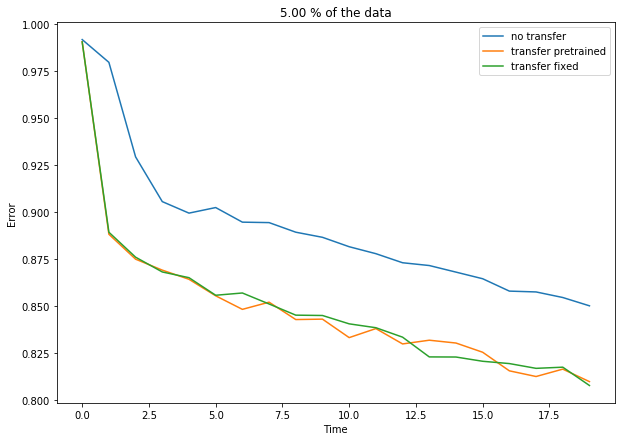

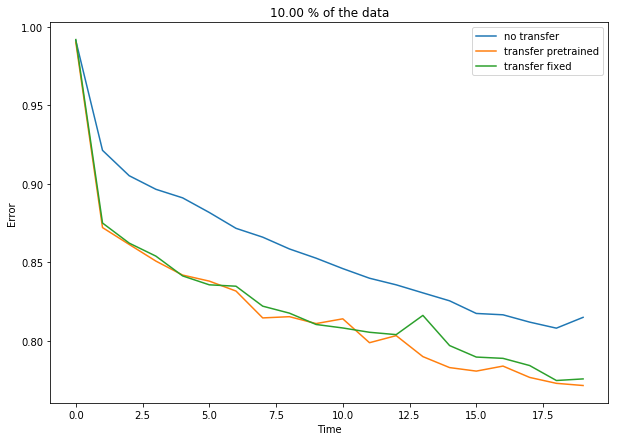

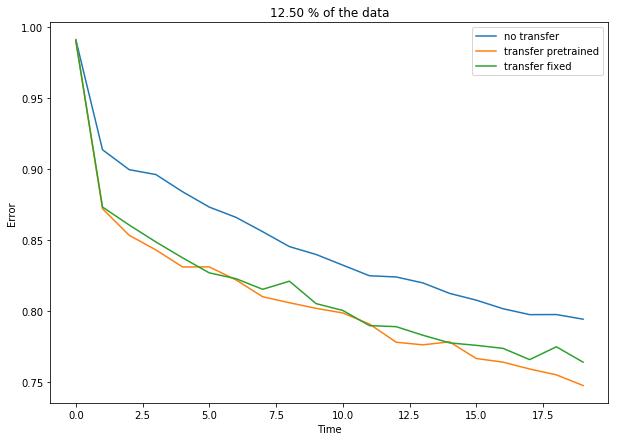

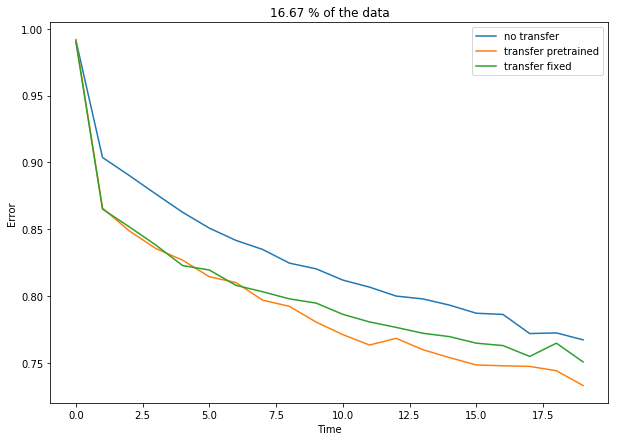

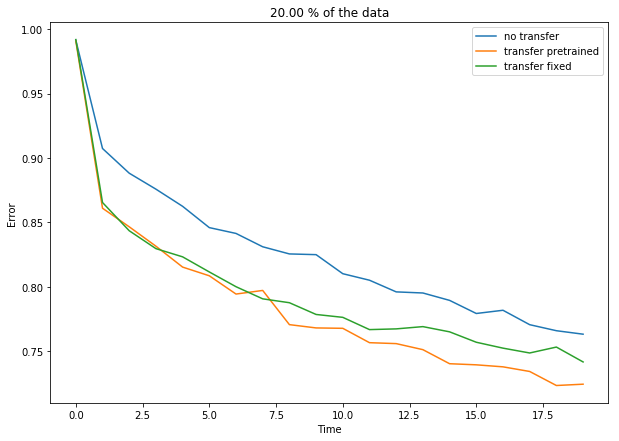

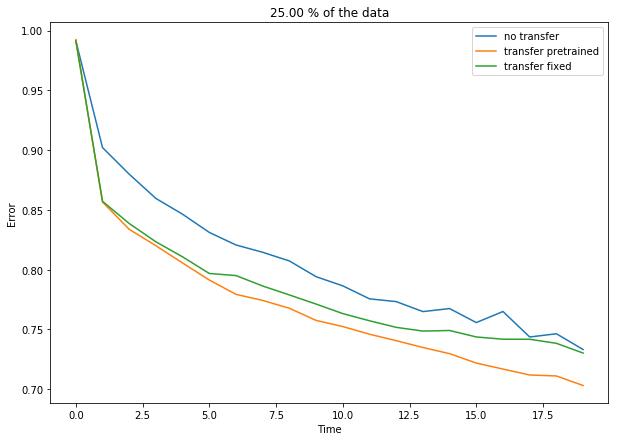

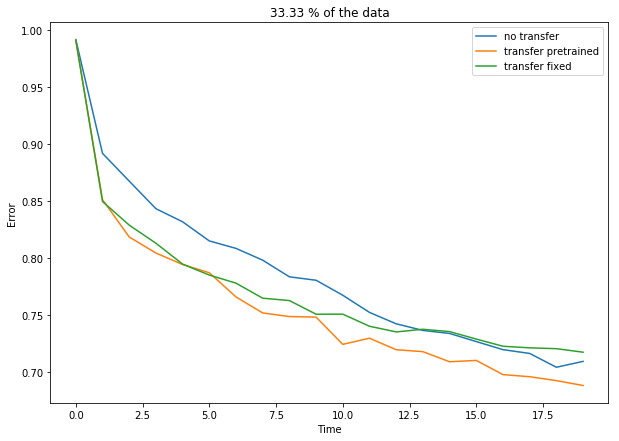

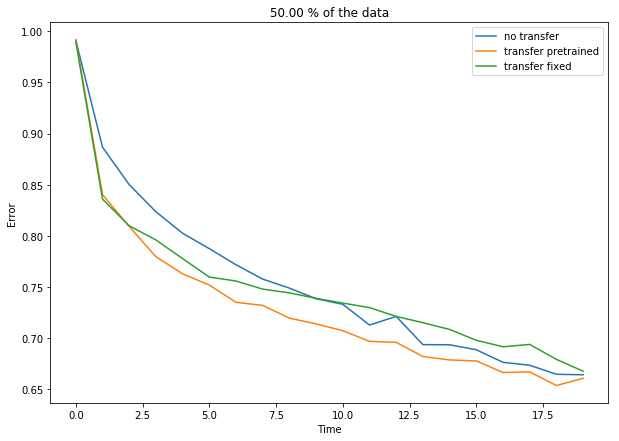

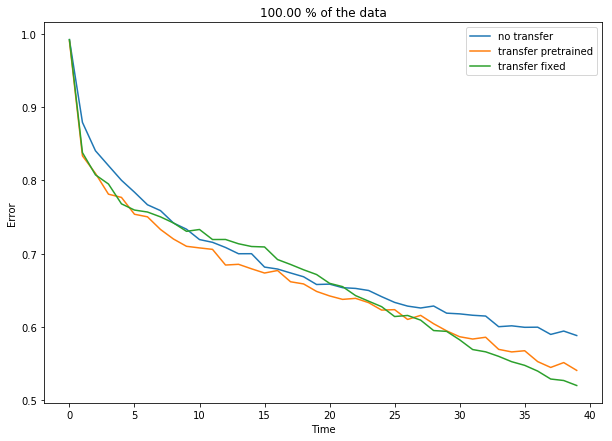

In [29]:
# 然后再绘制它们的误差曲线
for fraction in fractions:
    plt.figure(figsize = (10, 7))
    plt.title('{:.2f} % of the data'.format(100.0 / fraction))
    plt.plot(1 - one_curve[('no transfer', fraction)], label = 'no transfer')
    plt.plot(1 - one_curve[('transfer_pretrained', fraction)], label = 'transfer pretrained')
    plt.plot(1 - one_curve[('transfer_fixed', fraction)] , label = 'transfer fixed')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Error')

Text(0,0.5,'Error Rate')

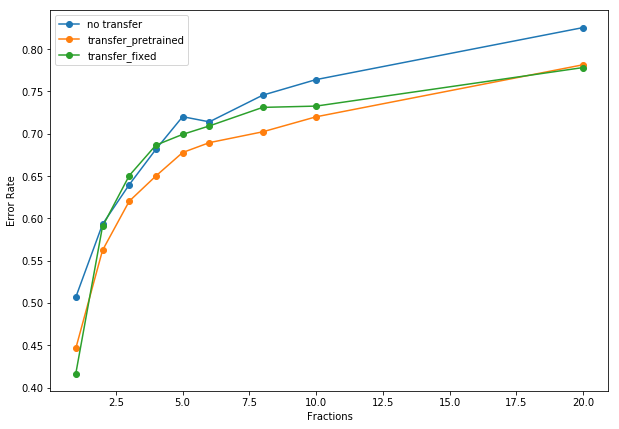

In [30]:
# 绘制测试准确度随着fraction变化的曲线
plt.figure(figsize = (10, 7))
for experiment in ['no transfer', 'transfer_pretrained', 'transfer_fixed']:
    testss = []
    for fraction in fractions:
        test = 1 - tests[(experiment, fraction)]
        testss.append(test)
    plt.plot(fractions, testss, 'o-', label = experiment)
plt.legend()
plt.xlabel('Fractions')
plt.ylabel('Error Rate')